# AI Personality Drift Simulation - Longitudinal Trends Analysis
 
This notebook analyzes longitudinal trends in simulation data, including:
- Assessment score trajectories over time
- Personality trait drift patterns
- Mechanistic analysis trends
- Change point detection
- Growth rate analysis
- Trajectory similarity analysis
 
**Author**: Mike Keeman  
**Date**: July 2025  
**Version**: 1.0

In [74]:
import sys
import os
sys.path.append('../../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

# Analysis imports
from analysis.statistical_analyzer import StatisticalAnalyzer
from analysis.visualization_toolkit import VisualizationToolkit
from analysis.longitudinal_analyzer import LongitudinalAnalyzer
from analysis.data_export import DataExporter

# Model imports
from models import Persona, AssessmentResult, PHQ9Result, GAD7Result, PSS10Result
from models.persona import PersonalityTrait

In [2]:
# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Initialize analysis tools
stats_analyzer = StatisticalAnalyzer()
viz_toolkit = VisualizationToolkit(style="publication")
longitudinal_analyzer = LongitudinalAnalyzer()
data_exporter = DataExporter()

# %%
# Create output directory
output_dir = Path("../../data/results/longitudinal_analysis")
output_dir.mkdir(parents=True, exist_ok=True)

## Load Simulation Data

In [3]:
# Load assessment data (sample data if files not found)
assessment_data_path = Path("../../data/simulation/assessment_results.csv")
if assessment_data_path.exists():
    assessment_data = pd.read_csv(assessment_data_path)
    print(f"Loaded {len(assessment_data)} assessment records")
else:
    # Create sample data for demonstration
    print("Assessment data not found, creating sample data...")
    np.random.seed(42)
    
    # Generate sample assessment data
    personas = ['persona_1', 'persona_2', 'persona_3']
    assessment_types = ['phq9', 'gad7', 'pss10']
    days = range(0, 30, 7)  # Weekly assessments
    
    assessment_data = []
    for persona in personas:
        for assessment_type in assessment_types:
            baseline_score = np.random.uniform(5, 15)
            for day in days:
                # Add some drift over time
                drift = np.random.normal(0, 0.5) * (day / 30)
                score = max(0, baseline_score + drift)
                
                assessment_data.append({
                    'assessment_id': f"{persona}_{assessment_type}_{day}",
                    'persona_id': persona,
                    'assessment_type': assessment_type,
                    'simulation_day': day,
                    'total_score': score,
                    'severity_level': 'mild' if score < 10 else 'moderate',
                    'response_consistency': np.random.uniform(0.7, 0.95),
                    'response_time_avg': np.random.uniform(2.0, 5.0),
                    'created_at': datetime.now().isoformat()
                })
    
    assessment_data = pd.DataFrame(assessment_data)
    print(f"Created sample data with {len(assessment_data)} records")

print("Assessment data summary:")
print(assessment_data.describe())

Assessment data not found, creating sample data...
Created sample data with 45 records
Assessment data summary:
       simulation_day  total_score  response_consistency  response_time_avg
count       45.000000    45.000000             45.000000          45.000000
mean        14.000000     9.646447              0.819445           3.196479
std         10.011357     2.767043              0.070280           0.872437
min          0.000000     4.872979              0.706355           2.020856
25%          7.000000     8.453395              0.760514           2.483664
50%         14.000000     8.928383              0.822363           2.935133
75%         21.000000    10.107473              0.878311           3.803345
max         28.000000    14.891386              0.940612           4.960661


In [4]:
# Load mechanistic data (sample data if files not found)
mechanistic_data_path = Path("../../data/simulation/mechanistic_analysis.csv")
if mechanistic_data_path.exists():
    mechanistic_data = pd.read_csv(mechanistic_data_path)
    print(f"Loaded {len(mechanistic_data)} mechanistic records")
else:
    # Create sample mechanistic data
    print("Mechanistic data not found, creating sample data...")
    
    mechanistic_data = []
    layers = range(1, 13)  # 12 transformer layers
    
    for persona in personas:
        for day in days:
            for layer in layers:
                # Generate attention weights and activation values
                attention_weight = np.random.uniform(0.1, 0.9)
                activation_value = np.random.uniform(-1.0, 1.0)
                drift_magnitude = np.random.uniform(0.0, 0.2)
                
                mechanistic_data.append({
                    'persona_id': persona,
                    'simulation_day': day,
                    'layer': layer,
                    'analysis_type': 'attention',
                    'attention_weight': attention_weight,
                    'activation_value': activation_value,
                    'drift_magnitude': drift_magnitude,
                    'created_at': datetime.now().isoformat()
                })
    
    mechanistic_data = pd.DataFrame(mechanistic_data)
    print(f"Created sample mechanistic data with {len(mechanistic_data)} records")

print("Mechanistic data summary:")
print(mechanistic_data.describe())

Mechanistic data not found, creating sample data...
Created sample mechanistic data with 180 records
Mechanistic data summary:
       simulation_day       layer  attention_weight  activation_value  \
count      180.000000  180.000000        180.000000        180.000000   
mean        14.000000    6.500000          0.480815          0.040494   
std          9.927109    3.461682          0.234681          0.592648   
min          0.000000    1.000000          0.108670         -0.977293   
25%          7.000000    3.750000          0.275056         -0.505999   
50%         14.000000    6.500000          0.483479          0.073203   
75%         21.000000    9.250000          0.661996          0.579546   
max         28.000000   12.000000          0.889821          0.999435   

       drift_magnitude  
count       180.000000  
mean          0.099404  
std           0.058770  
min           0.001012  
25%           0.045985  
50%           0.104675  
75%           0.145198  
max           0

## Assessment Score Trajectories

In [6]:
# Analyze assessment trajectories for each type
assessment_types = ['phq9', 'gad7', 'pss10']

for assessment_type in assessment_types:
    print(f"\n=== {assessment_type.upper()} Trajectory Analysis ===")
    
    # Analyze trajectories
    trajectory_results = longitudinal_analyzer.analyze_assessment_trajectories(
        assessment_data, assessment_type
    )
    
    # Print summary for each persona
    for persona_id, trajectory in trajectory_results.items():
        if isinstance(trajectory, dict) and 'error' not in trajectory:
            print(f"\nPersona: {persona_id}")
            print(f"  Baseline Score: {trajectory['baseline_score']:.2f}")
            print(f"  Final Score: {trajectory['final_score']:.2f}")
            print(f"  Score Change: {trajectory['score_change']:.2f}")
            print(f"  Change Percentage: {trajectory['score_change_percentage']:.1f}%")
            print(f"  Assessment Count: {trajectory['assessment_count']}")
            
            # Trend analysis
            trend = trajectory['trend_analysis']
            print(f"  Trend Direction: {trend['direction']}")
            print(f"  Trend Significance: {trend['significant']}")
            print(f"  R-squared: {trend['r_squared']:.3f}")


=== PHQ9 Trajectory Analysis ===

Persona: persona_1
  Baseline Score: 8.75
  Final Score: 9.13
  Score Change: 0.38
  Change Percentage: 4.4%
  Assessment Count: 5
  Trend Direction: increasing
  Trend Significance: False
  R-squared: 0.149

Persona: persona_2
  Baseline Score: 8.57
  Final Score: 9.00
  Score Change: 0.43
  Change Percentage: 5.1%
  Assessment Count: 5
  Trend Direction: increasing
  Trend Significance: False
  R-squared: 0.652

Persona: persona_3
  Baseline Score: 14.30
  Final Score: 14.89
  Score Change: 0.59
  Change Percentage: 4.2%
  Assessment Count: 5
  Trend Direction: increasing
  Trend Significance: False
  R-squared: 0.539

=== GAD7 Trajectory Analysis ===

Persona: persona_1
  Baseline Score: 8.66
  Final Score: 8.53
  Score Change: -0.14
  Change Percentage: -1.6%
  Assessment Count: 5
  Trend Direction: decreasing
  Trend Significance: False
  R-squared: 0.289

Persona: persona_2
  Baseline Score: 13.63
  Final Score: 14.33
  Score Change: 0.70
  Chan

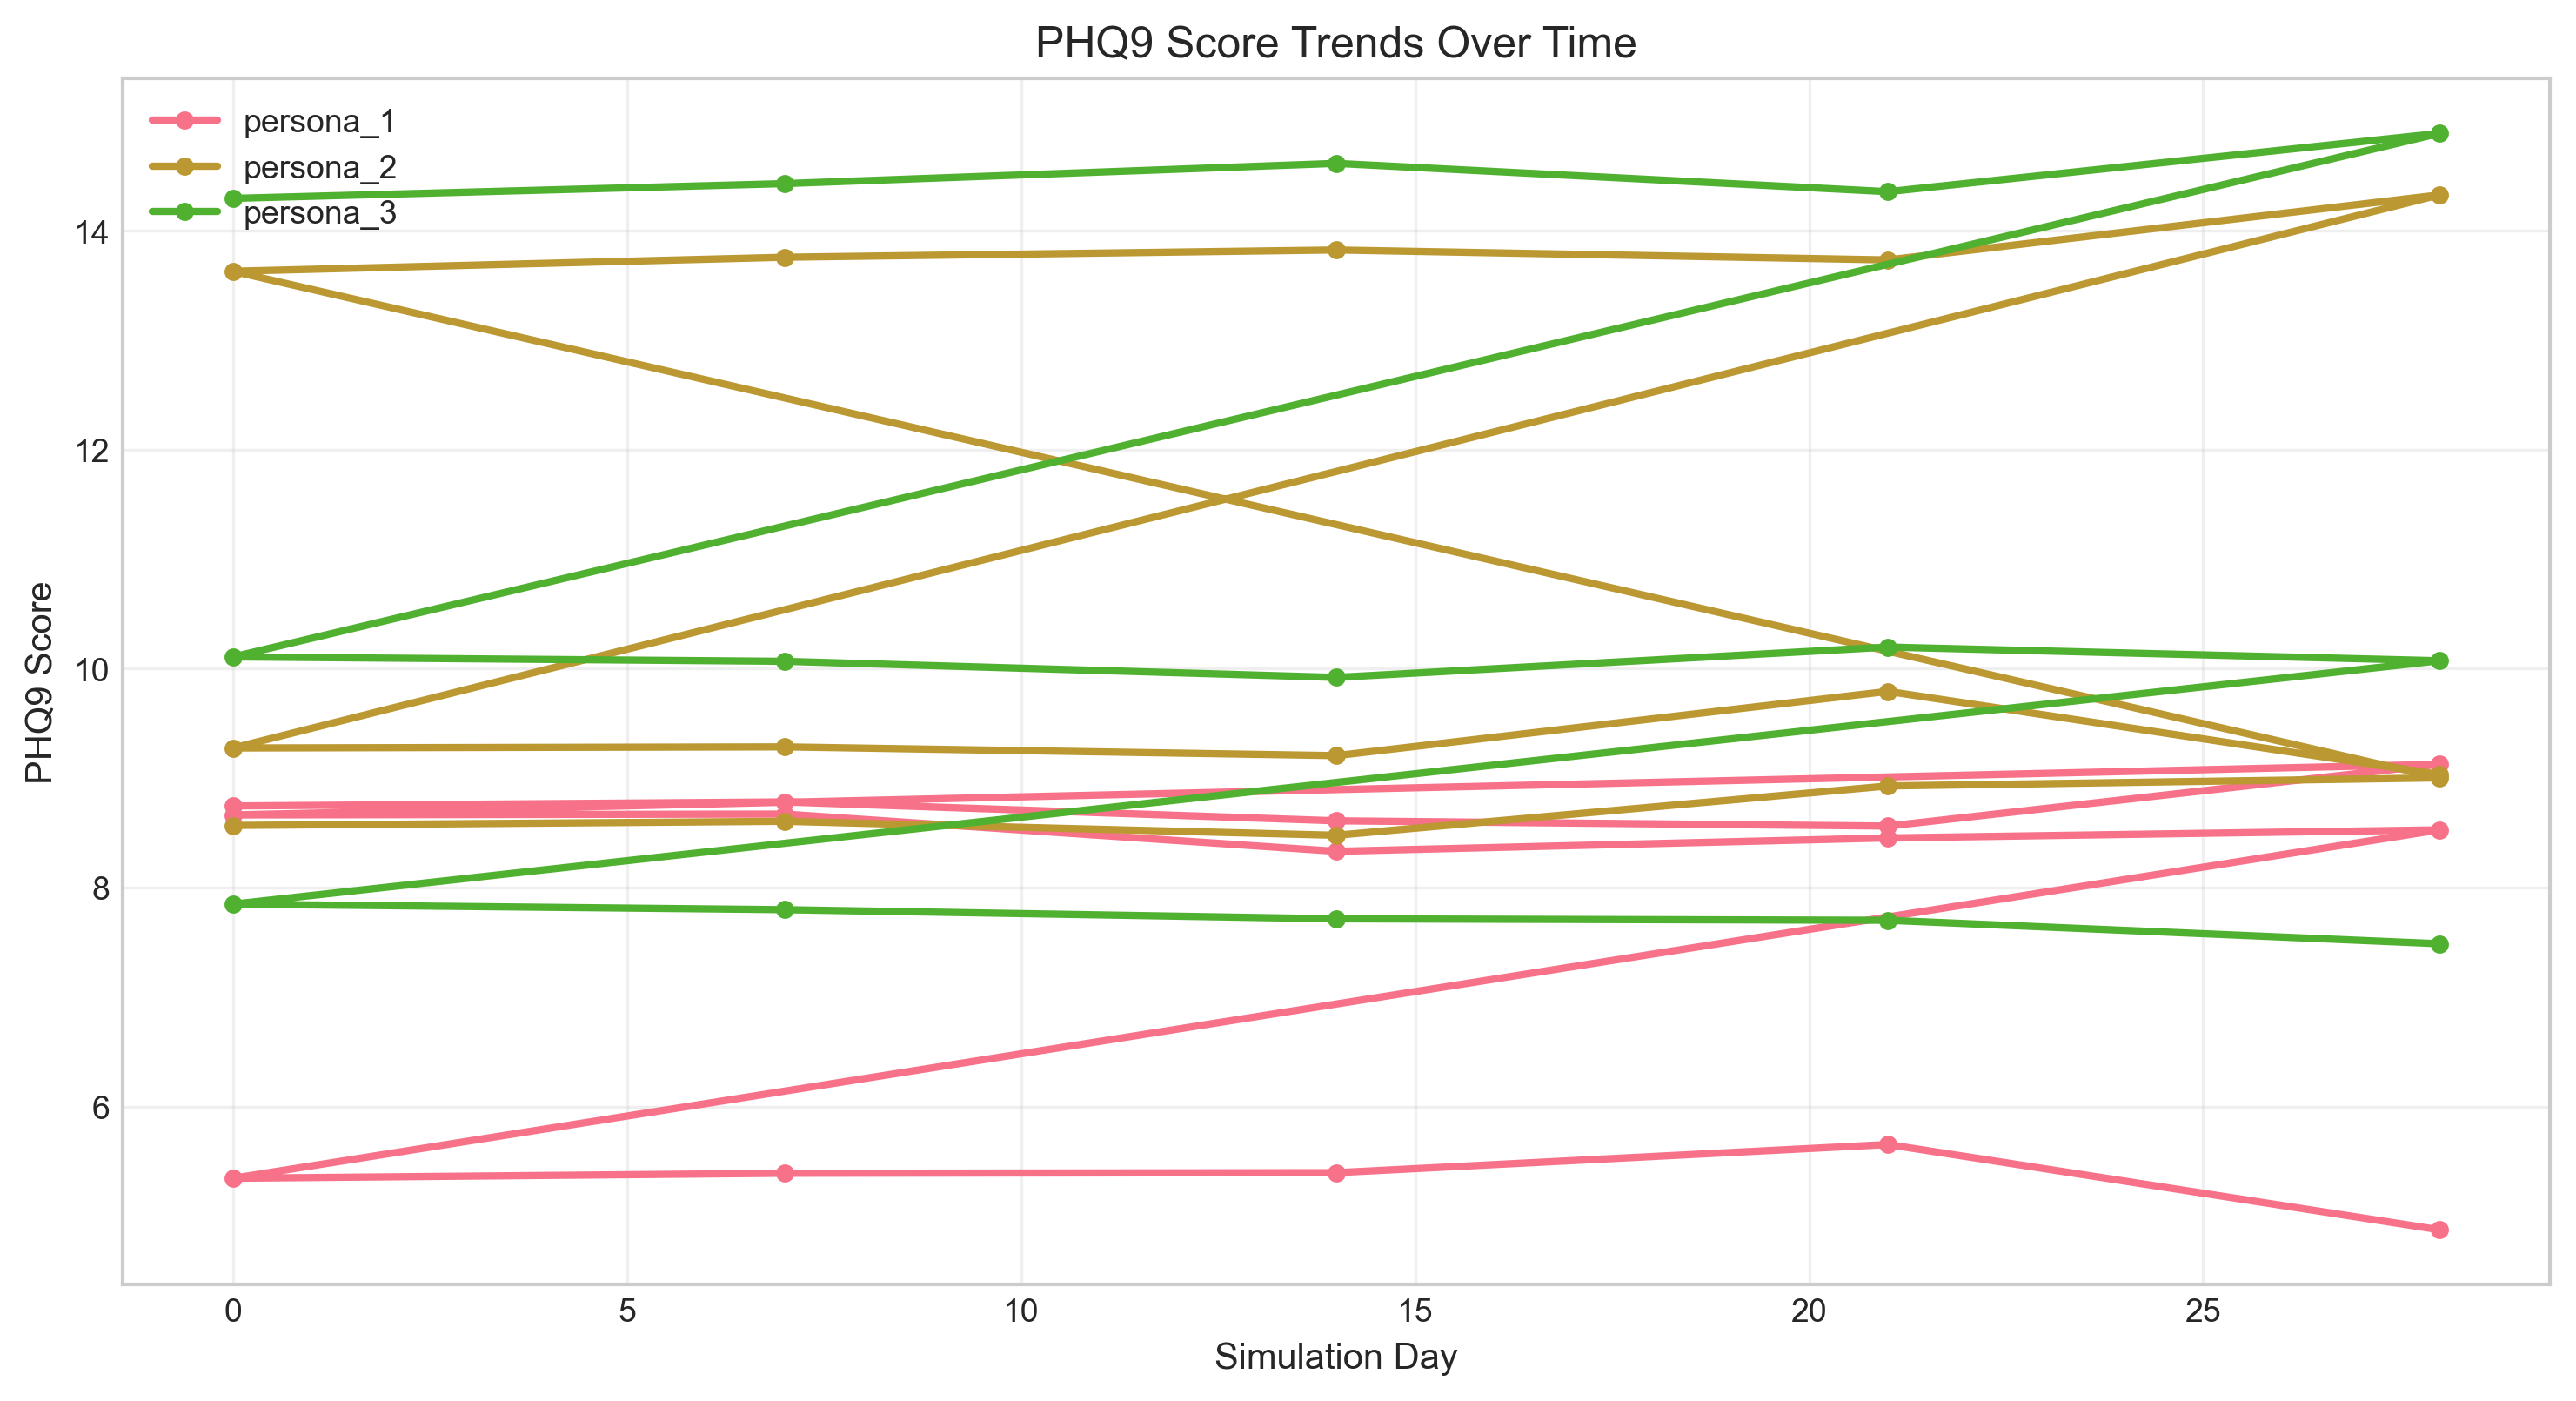

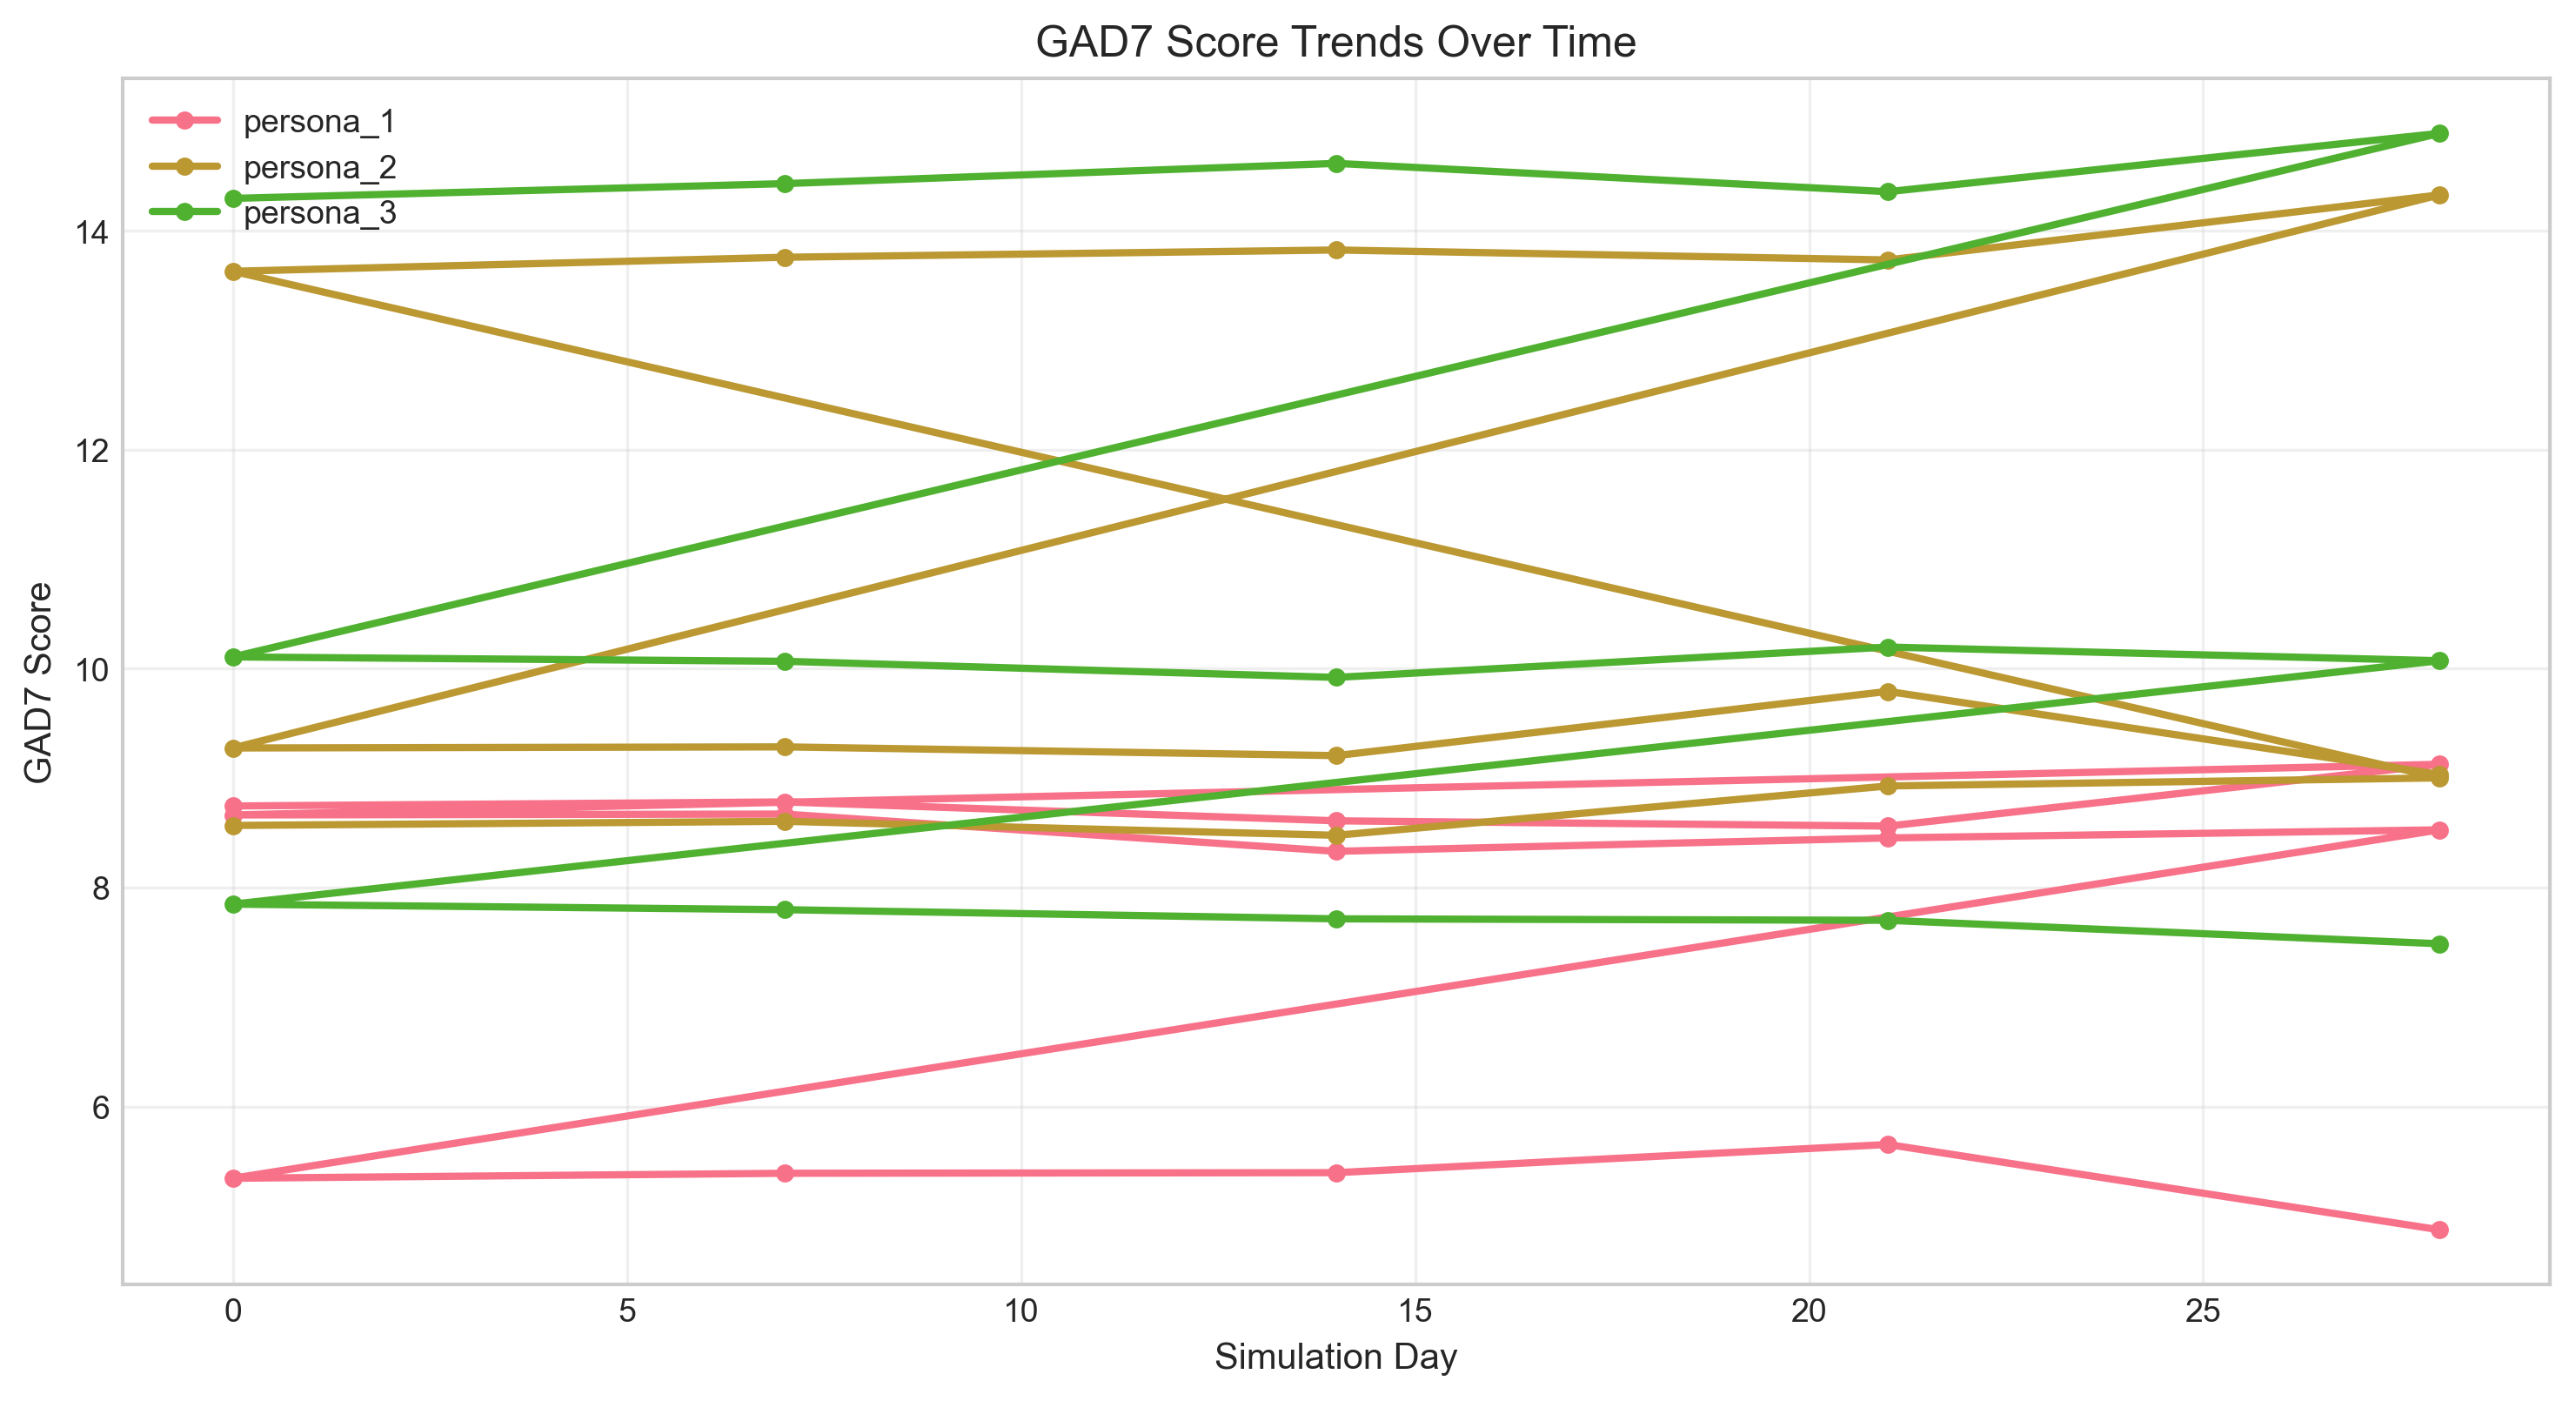

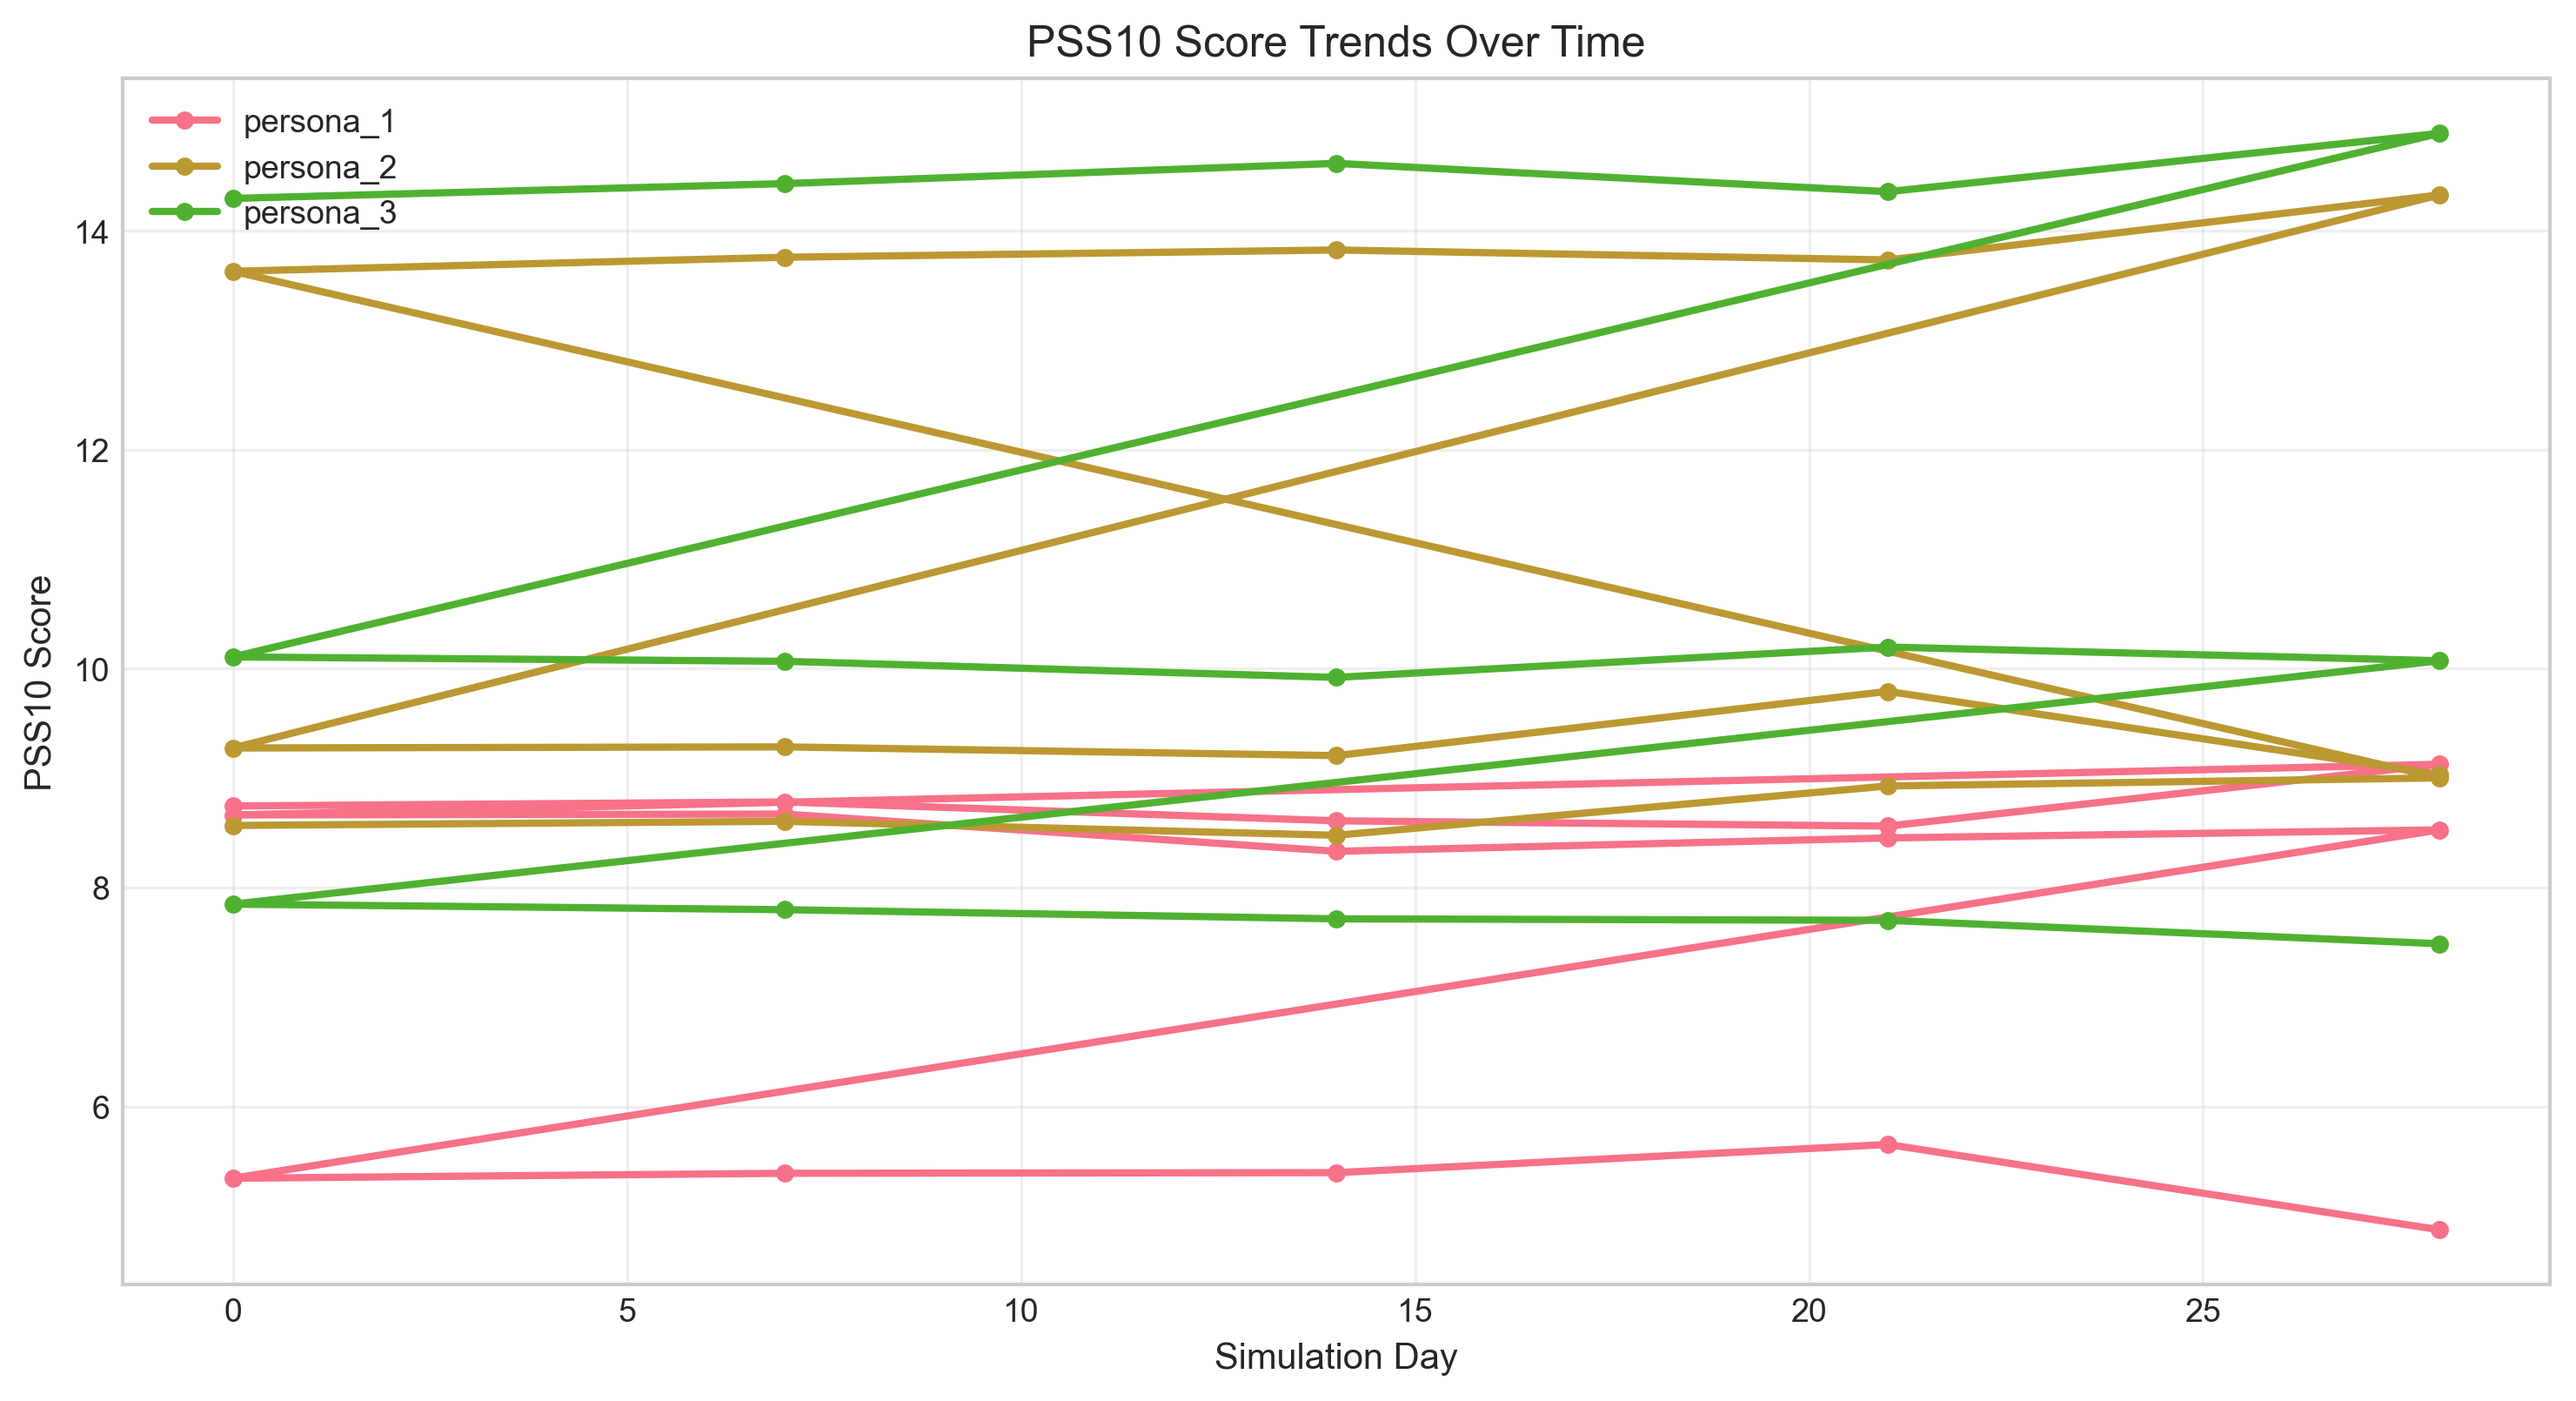

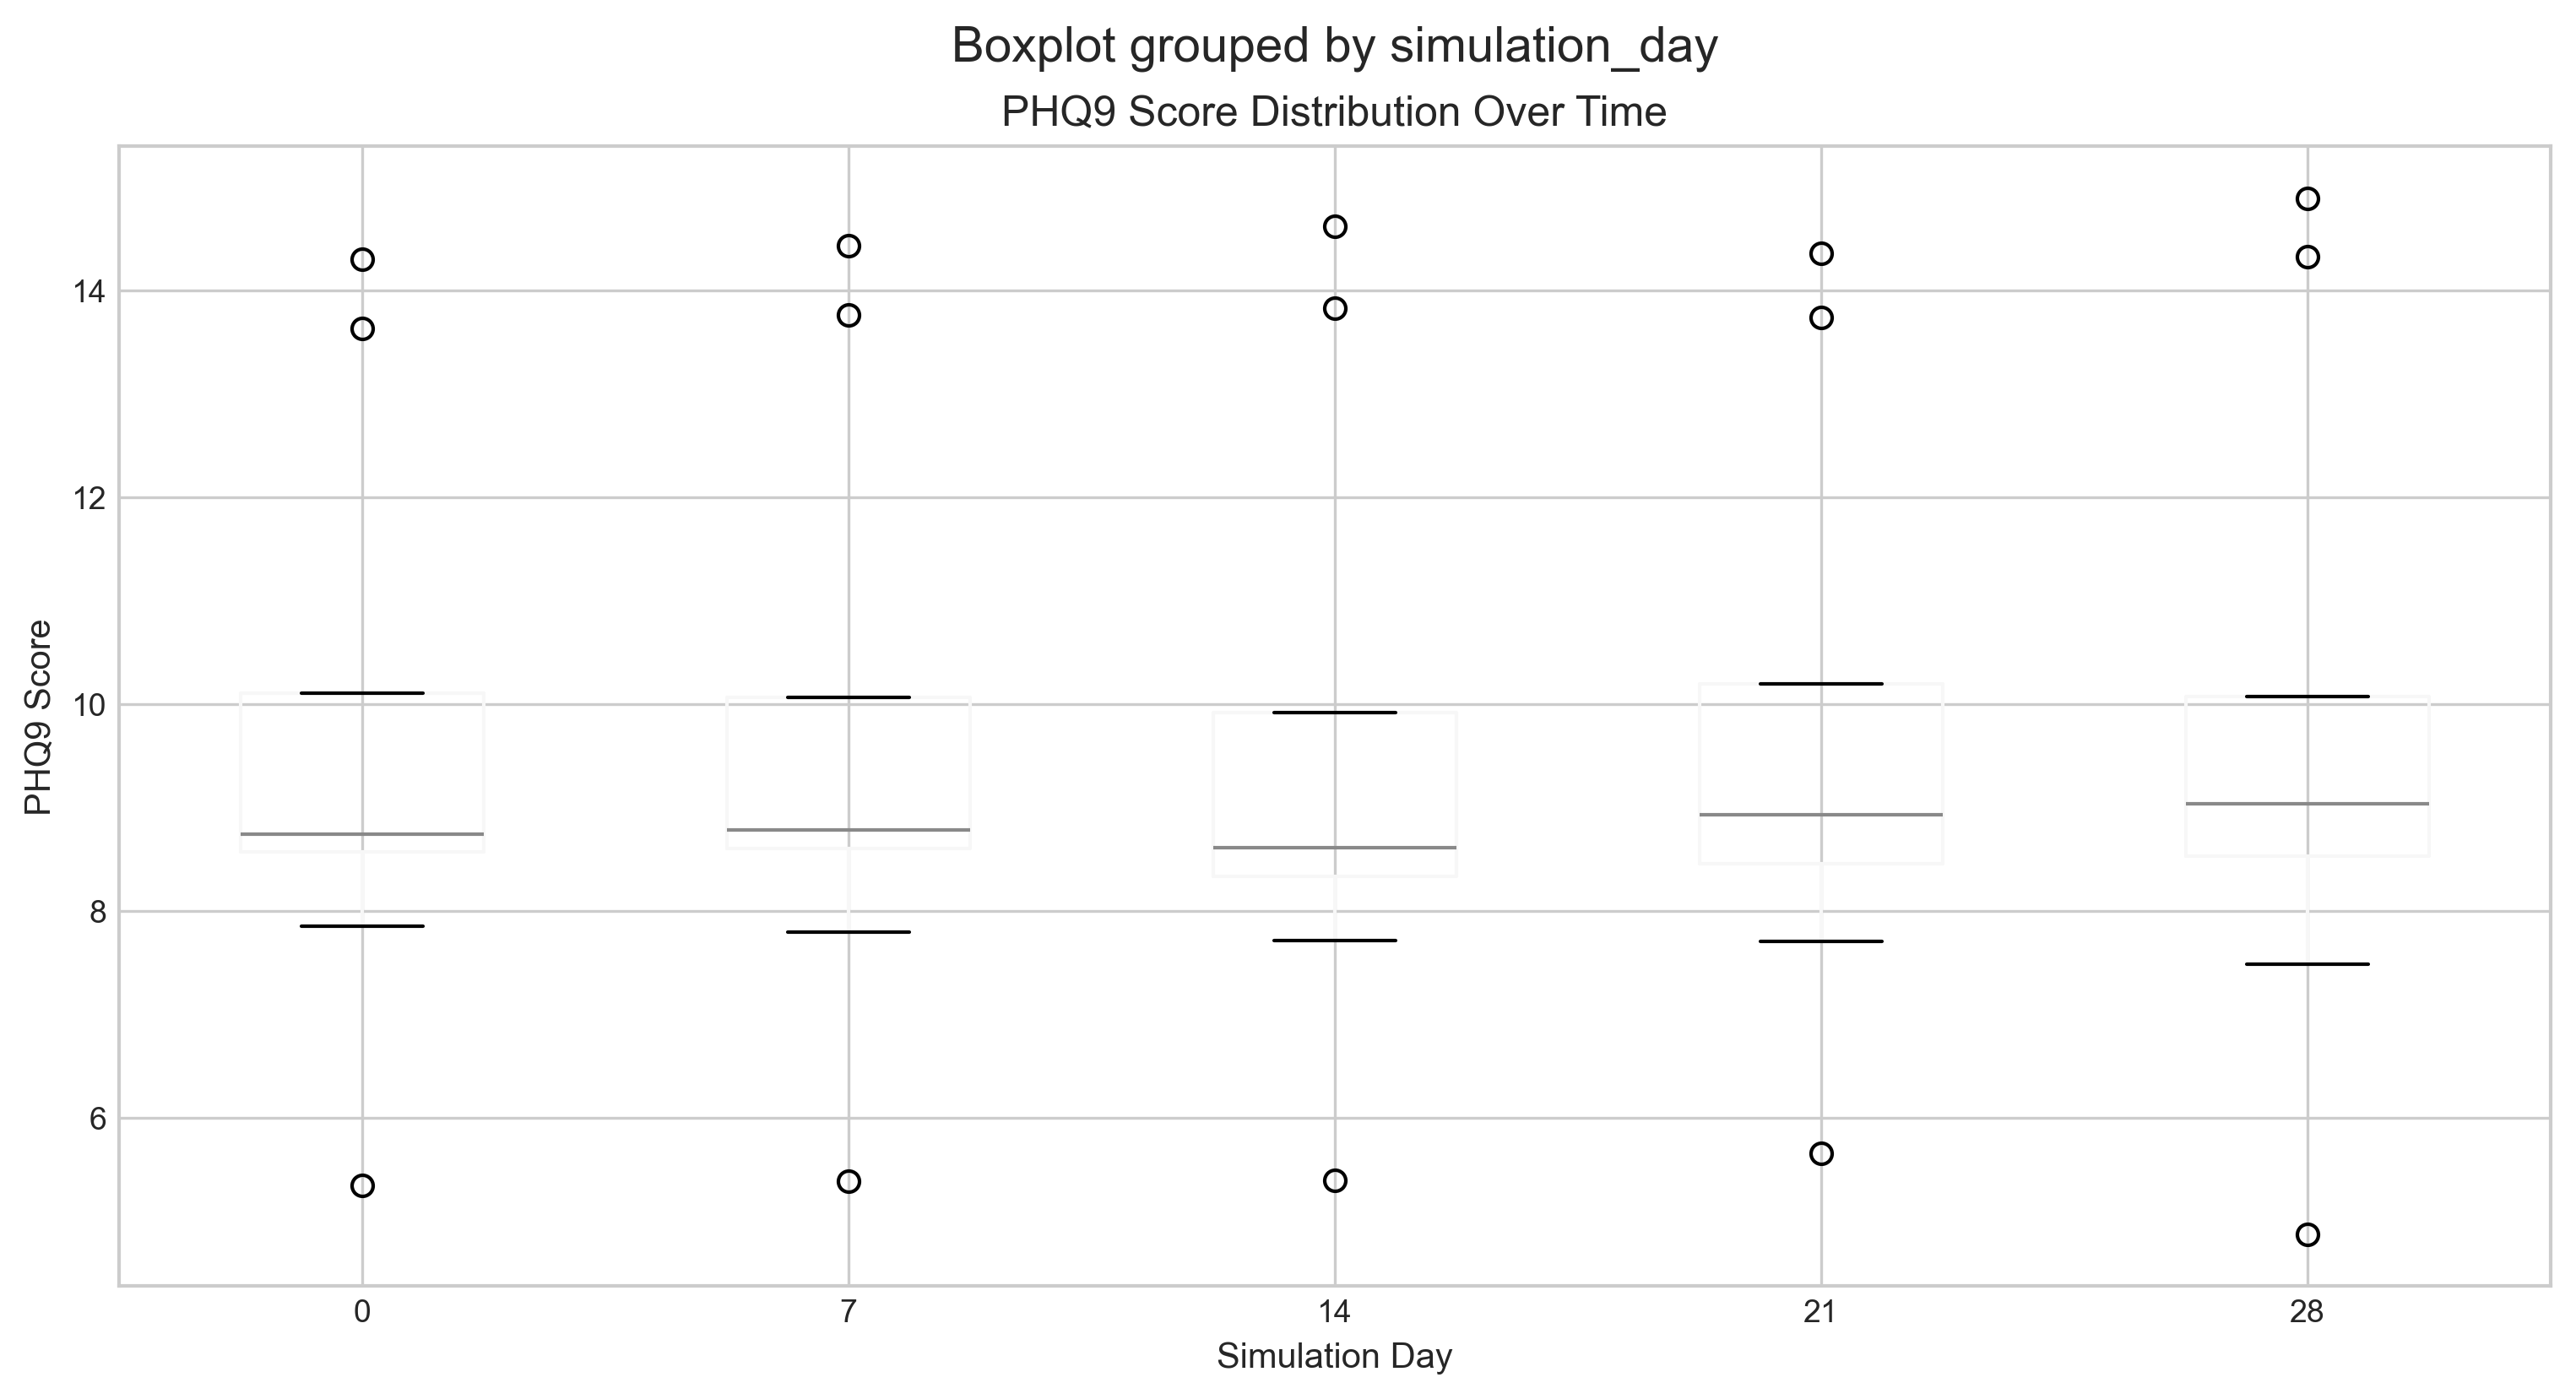

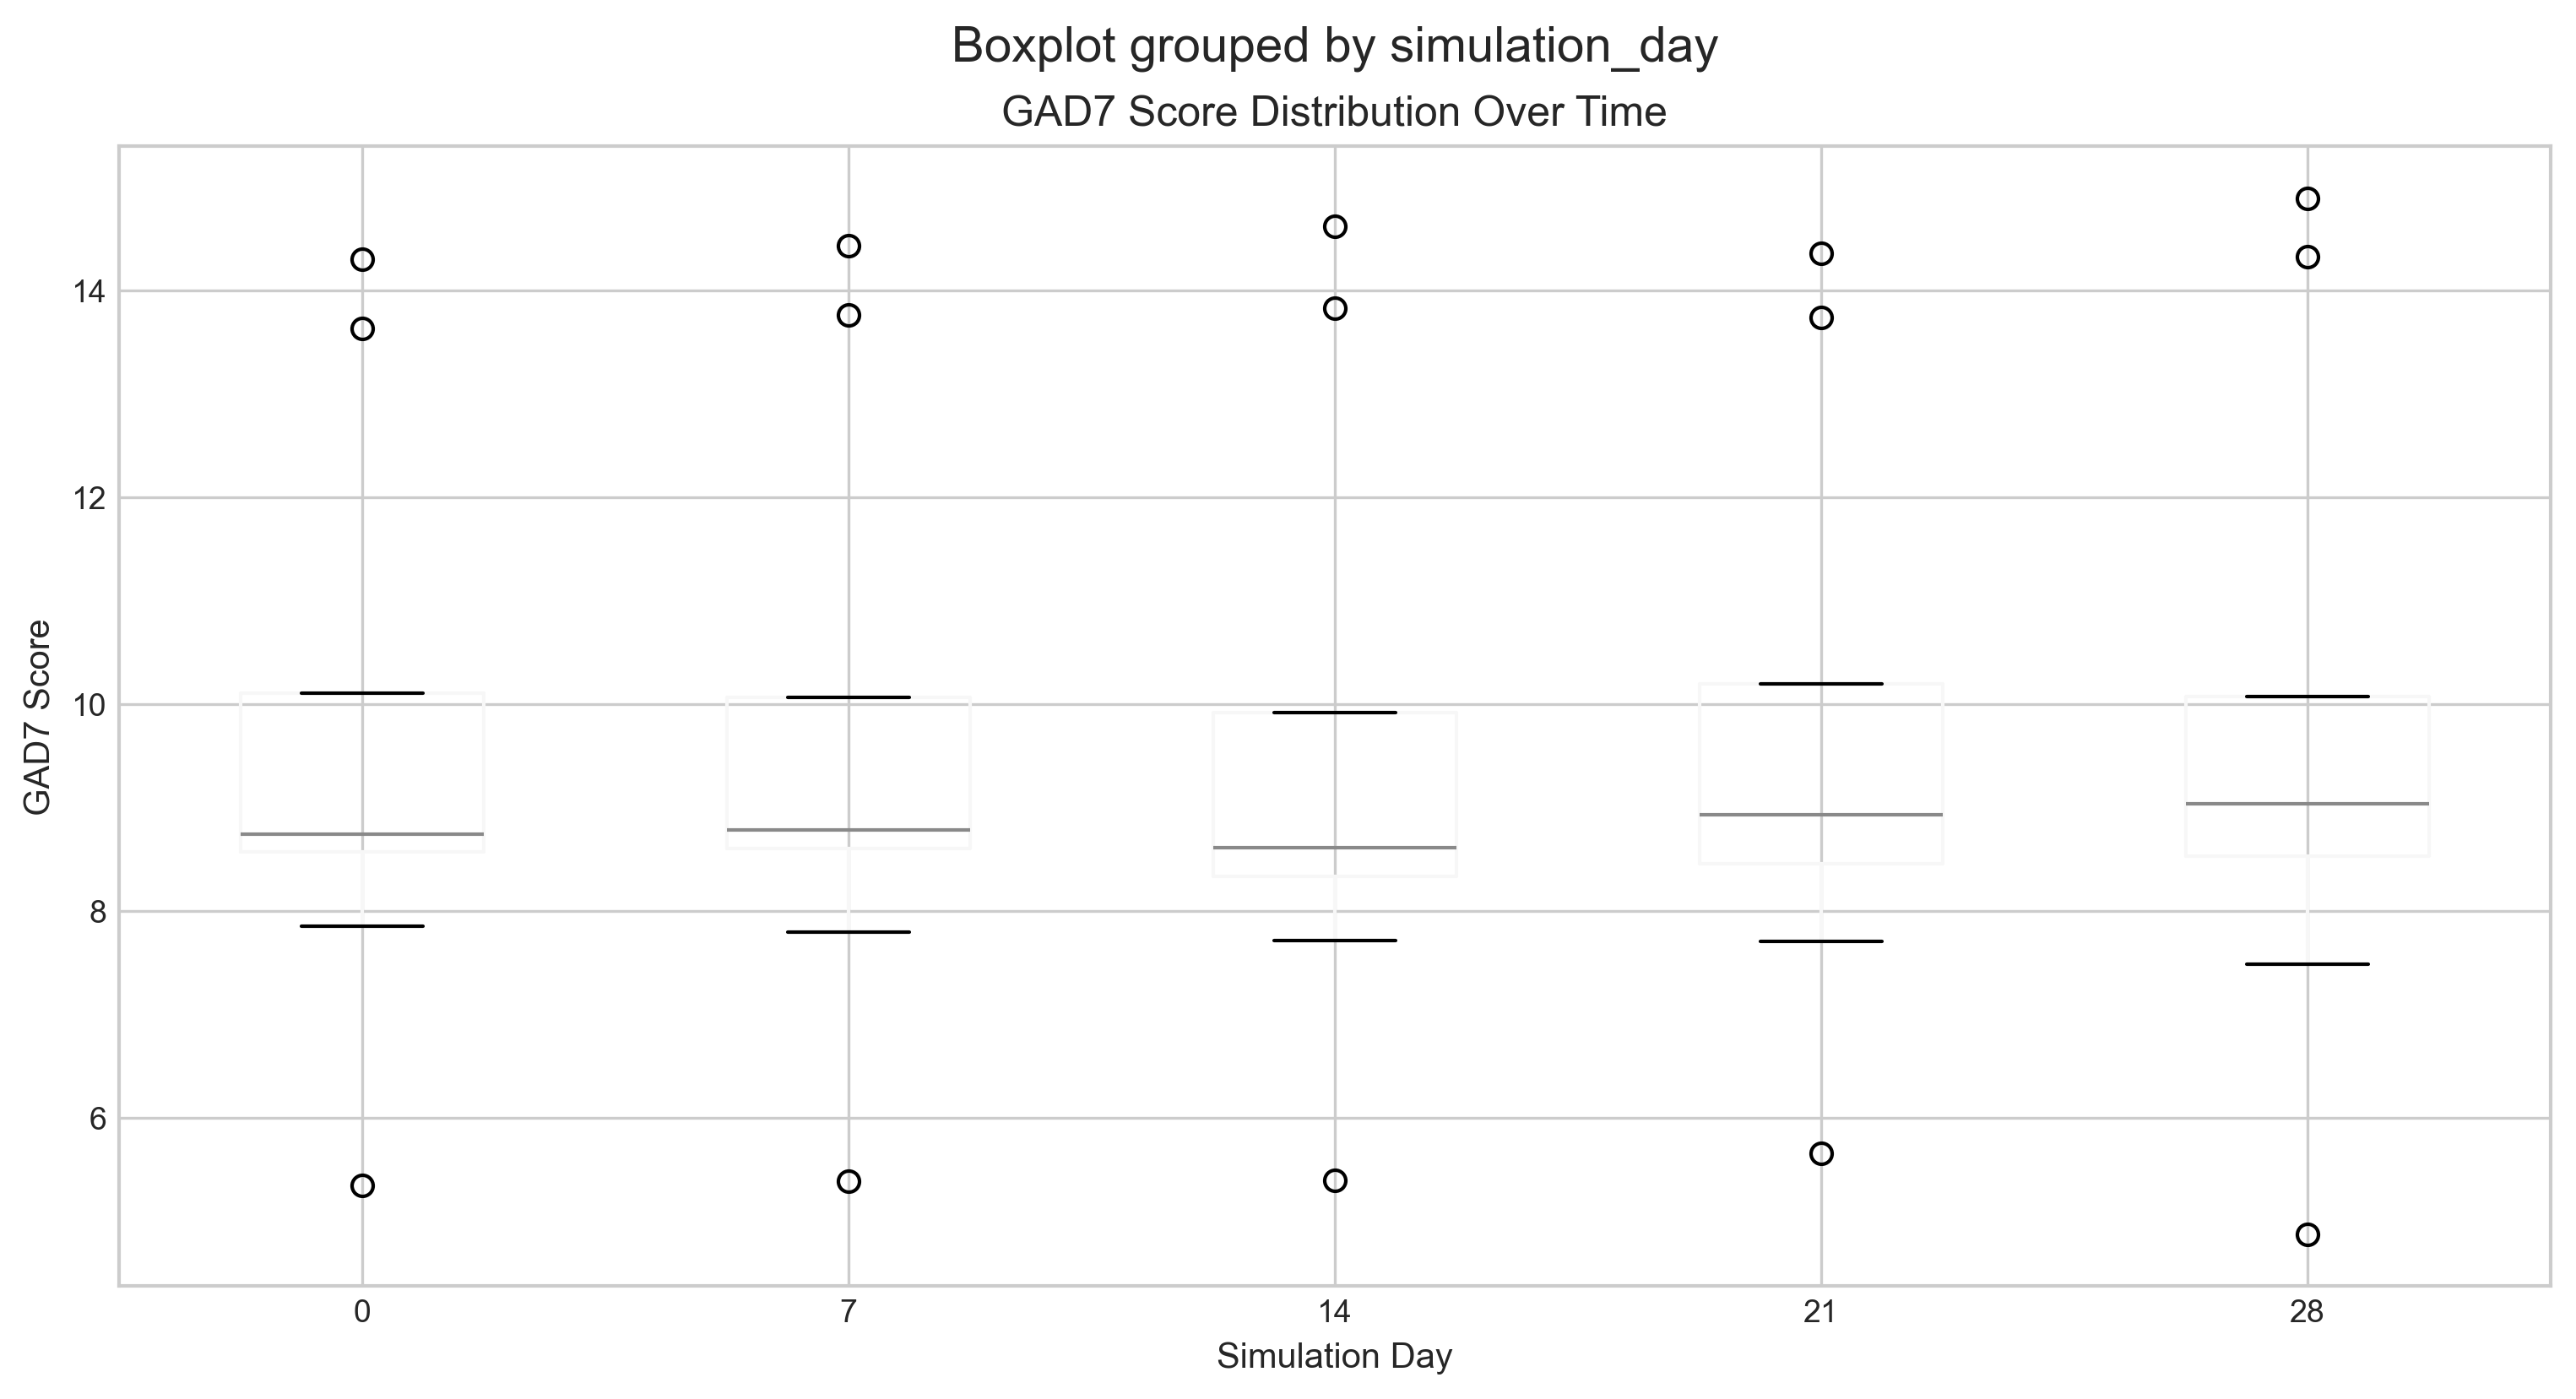

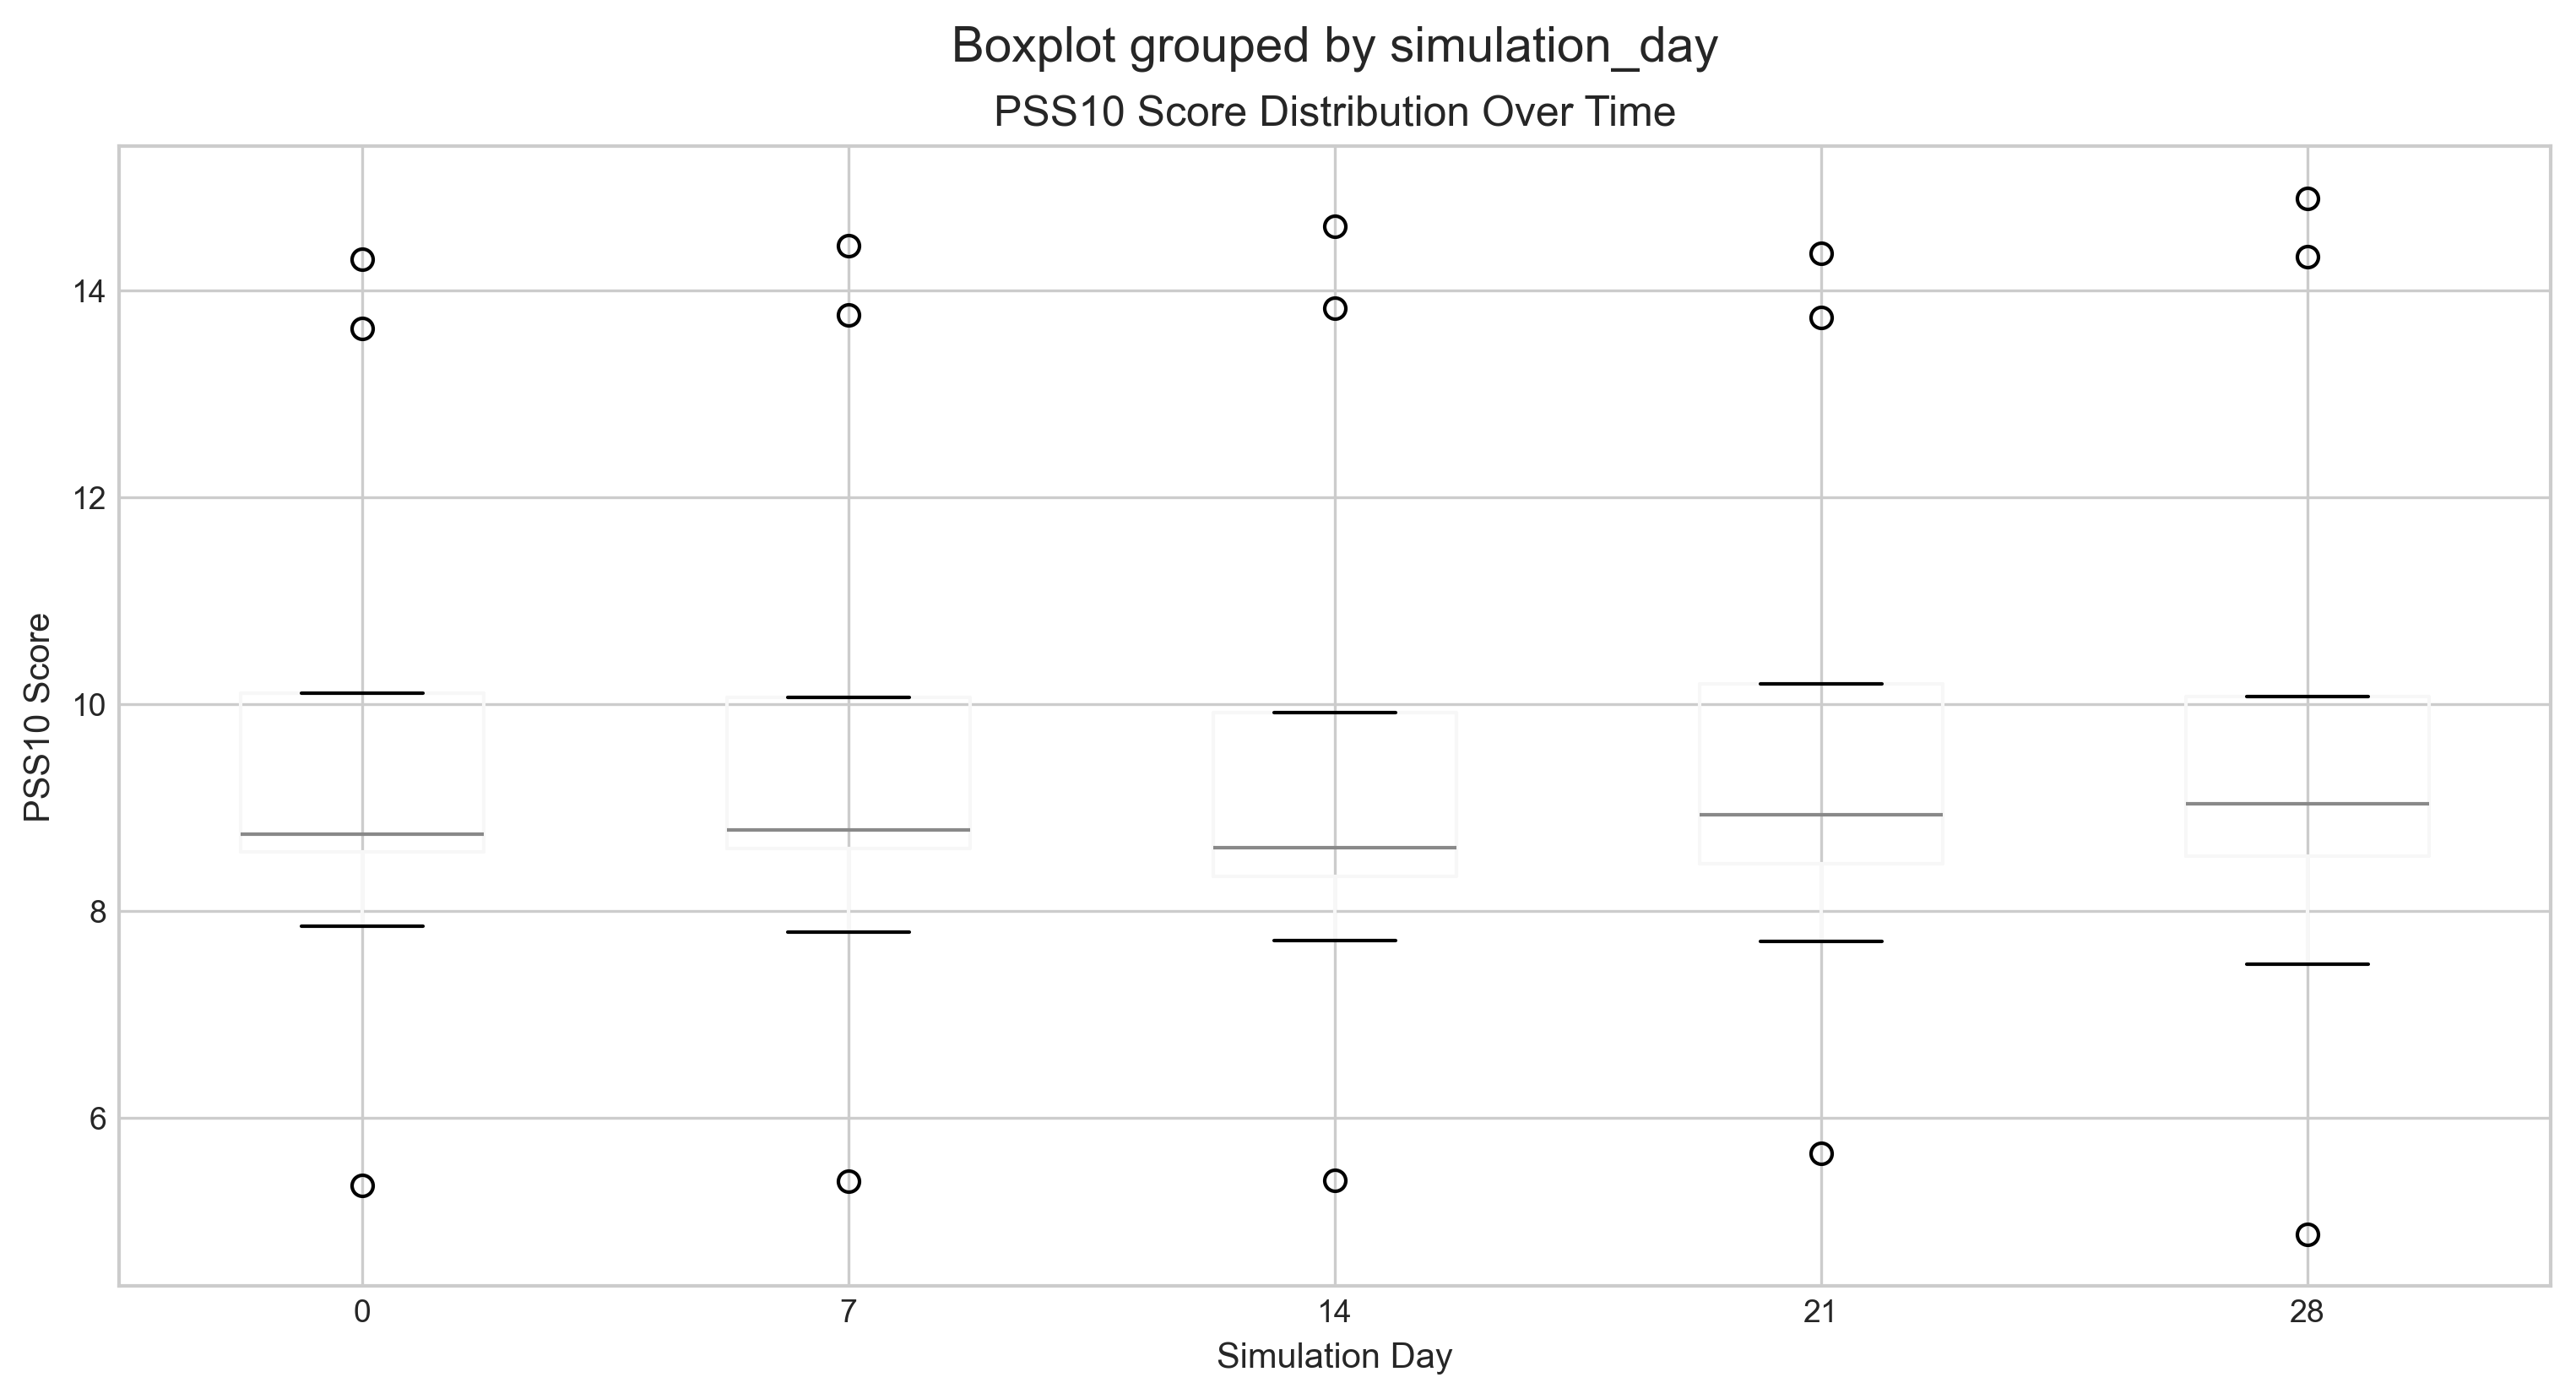

In [7]:
# Visualize assessment trends
for assessment_type in assessment_types:
    fig = viz_toolkit.plot_assessment_trends(
        assessment_data, assessment_type, plot_type="line"
    )
    plt.savefig(output_dir / f"{assessment_type}_trends_line.png", bbox_inches='tight')
    plt.show()

# %%
# Box plots for assessment distributions
for assessment_type in assessment_types:
    fig = viz_toolkit.plot_assessment_trends(
        assessment_data, assessment_type, plot_type="box"
    )
    plt.savefig(output_dir / f"{assessment_type}_trends_box.png", bbox_inches='tight')
    plt.show()

## Growth Rate Analysis

In [8]:
# Calculate growth rates for each assessment type
for assessment_type in assessment_types:
    print(f"\n=== {assessment_type.upper()} Growth Rate Analysis ===")
    
    growth_rates = longitudinal_analyzer.calculate_growth_rates(
        assessment_data, assessment_type
    )
    
    for persona_id, growth in growth_rates.items():
        print(f"\nPersona: {persona_id}")
        print(f"  Linear Growth Rate: {growth['linear_growth_rate']:.4f}")
        print(f"  Average Daily Change: {growth['avg_daily_change']:.4f}")
        print(f"  Acceleration: {growth['acceleration']:.4f}")
        print(f"  R-squared: {growth['r_squared']:.3f}")
        print(f"  Significant: {growth['significant']}")
        print(f"  Assessment Count: {growth['assessment_count']}")
        print(f"  Time Span: {growth['time_span']} days")


=== PHQ9 Growth Rate Analysis ===

Persona: persona_1
  Linear Growth Rate: 0.0077
  Average Daily Change: 0.0953
  Acceleration: 0.1759
  R-squared: 0.149
  Significant: False
  Assessment Count: 5
  Time Span: 28 days

Persona: persona_2
  Linear Growth Rate: 0.0170
  Average Daily Change: 0.1086
  Acceleration: 0.0120
  R-squared: 0.652
  Significant: False
  Assessment Count: 5
  Time Span: 28 days

Persona: persona_3
  Linear Growth Rate: 0.0159
  Average Daily Change: 0.1486
  Acceleration: 0.1326
  R-squared: 0.539
  Significant: False
  Assessment Count: 5
  Time Span: 28 days

=== GAD7 Growth Rate Analysis ===

Persona: persona_1
  Linear Growth Rate: -0.0070
  Average Daily Change: -0.0340
  Acceleration: 0.0221
  R-squared: 0.289
  Significant: False
  Assessment Count: 5
  Time Span: 28 days

Persona: persona_2
  Linear Growth Rate: 0.0196
  Average Daily Change: 0.1745
  Acceleration: 0.1553
  R-squared: 0.628
  Significant: False
  Assessment Count: 5
  Time Span: 28 day

## Change Point Detection

In [9]:
# Detect change points in assessment trajectories
for assessment_type in assessment_types:
    print(f"\n=== {assessment_type.upper()} Change Point Detection ===")
    
    type_data = assessment_data[assessment_data['assessment_type'] == assessment_type]
    
    for persona_id in type_data['persona_id'].unique():
        persona_data = type_data[type_data['persona_id'] == persona_id].sort_values('simulation_day')
        
        if len(persona_data) >= 3:
            change_points = stats_analyzer.detect_change_points(
                persona_data['total_score'].values, method="cusum"
            )
            
            print(f"\nPersona: {persona_id}")
            print(f"  Change Points: {change_points['change_points']}")
            print(f"  Method: {change_points['method']}")
            
            if change_points['change_points']:
                print(f"  Number of Change Points: {len(change_points['change_points'])}")
            else:
                print("  No significant change points detected")


=== PHQ9 Change Point Detection ===

Persona: persona_1
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

Persona: persona_2
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

Persona: persona_3
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

=== GAD7 Change Point Detection ===

Persona: persona_1
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

Persona: persona_2
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

Persona: persona_3
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

=== PSS10 Change Point Detection ===

Persona: persona_1
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

Persona: persona_2
  Change Points: []
  Method: CUSUM control chart
  No significant change points detected

Persona

## Trajectory Pattern Detection

In [10]:
# Detect trajectory patterns
for assessment_type in assessment_types:
    print(f"\n=== {assessment_type.upper()} Trajectory Pattern Detection ===")
    
    patterns = longitudinal_analyzer.detect_trajectory_patterns(
        assessment_data, assessment_type
    )
    
    for persona_id, persona_patterns in patterns.items():
        print(f"\nPersona: {persona_id}")
        for pattern_type, pattern_data in persona_patterns.items():
            print(f"  {pattern_type}: {pattern_data}")


=== PHQ9 Trajectory Pattern Detection ===

Persona: persona_1
  stable: {'slope': np.float64(0.007728581735644648), 'r_squared': np.float64(0.3856891630252524), 'p_value': np.float64(0.5213876096640173)}
  accelerating: {'acceleration': np.float64(0.17587062735862524)}

Persona: persona_2
  accelerating: {'acceleration': np.float64(0.01197925320597193)}

Persona: persona_3
  accelerating: {'acceleration': np.float64(0.13261453122406586)}

=== GAD7 Trajectory Pattern Detection ===

Persona: persona_1
  stable: {'slope': np.float64(-0.007004990454650923), 'r_squared': np.float64(-0.5373267857710018), 'p_value': np.float64(0.35037297646208115)}
  accelerating: {'acceleration': np.float64(0.022073833673709114)}

Persona: persona_2
  accelerating: {'acceleration': np.float64(0.15526022877408371)}

Persona: persona_3
  stable: {'slope': np.float64(0.0008663306042761729), 'r_squared': np.float64(0.09579815378061374), 'p_value': np.float64(0.8782128250126031)}
  decelerating: {'acceleration':

## Personality Trait Drift Analysis

In [15]:
# Load persona data for trait analysis
persona_data_path = Path("../../config/personas")
if persona_data_path.exists():
    import yaml
    
    personas = []
    for file in persona_data_path.glob("*.yaml"):
        with open(file, 'r') as f:
            config = yaml.safe_load(f)
        
        # Create sample state with drift
        from models import PersonaBaseline, PersonaState, Persona
        
        baseline = PersonaBaseline(**config)
        
        # Generate valid clinical scores within the model constraints
        # PHQ-9: 0-27, GAD-7: 0-21, PSS-10: 0-40
        current_phq9 = max(0.0, min(27.0, baseline.baseline_phq9 + np.random.normal(0, 2)))
        current_gad7 = max(0.0, min(21.0, baseline.baseline_gad7 + np.random.normal(0, 2)))
        current_pss10 = max(0.0, min(40.0, baseline.baseline_pss10 + np.random.normal(0, 2)))
        
        state = PersonaState(
            persona_id=baseline.name.lower().replace(" ", "_"),
            simulation_day=30,
            last_assessment_day=28,
            current_phq9=current_phq9,
            current_gad7=current_gad7,
            current_pss10=current_pss10,
            drift_magnitude=np.random.uniform(0.1, 0.3),
            emotional_state="neutral",
            stress_level=np.random.uniform(0.0, 5.0)  # Stress level 0-10, but keep reasonable
        )
        
        # Add some trait changes (keep small to avoid exceeding 0-1 bounds)
        trait_changes = {
            'openness': np.random.normal(0, 0.02),
            'conscientiousness': np.random.normal(0, 0.02),
            'extraversion': np.random.normal(0, 0.02),
            'agreeableness': np.random.normal(0, 0.02),
            'neuroticism': np.random.normal(0, 0.02)
        }
        state.trait_changes = trait_changes
        
        persona = Persona(baseline=baseline, state=state)
        # exclude test persona - its for dev
        if persona.baseline.name != "Test Persona":
            personas.append(persona)
    
    print(f"Loaded {len(personas)} personas with drift data")
else:
    print("Persona config not found, skipping trait drift analysis")

Loaded 3 personas with drift data


In [16]:
# Analyze personality trait trajectories
if 'personas' in locals() and personas:
    trait_trajectories = longitudinal_analyzer.analyze_personality_trajectories(personas)
    
    print("=== Personality Trait Trajectory Analysis ===")
    
    for trait, trajectories in trait_trajectories.items():
        print(f"\n{trait.title()} Trajectories:")
        for trajectory in trajectories:
            print(f"  {trajectory['persona_id']}:")
            print(f"    Baseline: {trajectory['baseline_value']:.3f}")
            print(f"    Current: {trajectory['current_value']:.3f}")
            print(f"    Change: {trajectory['change_magnitude']:.3f}")
            print(f"    Change %: {trajectory['change_percentage']:.1f}%")

=== Personality Trait Trajectory Analysis ===

Openness Trajectories:
  alfred:
    Baseline: 0.300
    Current: 0.288
    Change: -0.012
    Change %: -3.9%
  kara:
    Baseline: 0.800
    Current: 0.810
    Change: 0.010
    Change %: 1.3%
  marcus:
    Baseline: 0.700
    Current: 0.713
    Change: 0.013
    Change %: 1.9%

Conscientiousness Trajectories:
  alfred:
    Baseline: 0.900
    Current: 0.917
    Change: 0.017
    Change %: 1.9%
  kara:
    Baseline: 0.600
    Current: 0.584
    Change: -0.016
    Change %: -2.7%
  marcus:
    Baseline: 0.800
    Current: 0.851
    Change: 0.051
    Change %: 6.4%

Extraversion Trajectories:
  alfred:
    Baseline: 0.200
    Current: 0.154
    Change: -0.046
    Change %: -23.2%
  kara:
    Baseline: 0.900
    Current: 0.897
    Change: -0.003
    Change %: -0.4%
  marcus:
    Baseline: 0.400
    Current: 0.378
    Change: -0.022
    Change %: -5.5%

Agreeableness Trajectories:
  alfred:
    Baseline: 0.500
    Current: 0.495
    Change: 

## Mechanistic Analysis Trends

In [19]:
# Analyze mechanistic trajectories
analysis_types = ['attention', 'activation']

for analysis_type in analysis_types:
    print(f"\n=== {analysis_type.title()} Mechanistic Analysis ===")
    
    # Check if this analysis type exists in the data
    type_data = mechanistic_data[mechanistic_data['analysis_type'] == analysis_type]
    print(f"Data for {analysis_type}: {len(type_data)} records")
    
    if len(type_data) == 0:
        print(f"No data found for analysis type: {analysis_type}")
        continue
    
    mechanistic_trajectories = longitudinal_analyzer.analyze_mechanistic_trajectories(
        mechanistic_data, analysis_type
    )
    
    # Add debugging to understand the structure
    print(f"Mechanistic trajectories type: {type(mechanistic_trajectories)}")
    print(f"Mechanistic trajectories keys: {list(mechanistic_trajectories.keys())}")
    
    for persona_id, persona_trajectory in mechanistic_trajectories.items():
        print(f"\nPersona: {persona_id}")
        print(f"Trajectory type: {type(persona_trajectory)}")
        
        # Check if it's an error message
        if isinstance(persona_trajectory, dict) and 'error' in persona_trajectory:
            print(f"Error: {persona_trajectory['error']}")
            continue
            
        # Check if it has the expected structure
        if isinstance(persona_trajectory, dict) and 'layers' in persona_trajectory:
            for layer, layer_trajectory in persona_trajectory['layers'].items():
                print(f"  Layer {layer}:")
                print(f"    Baseline Value: {layer_trajectory['baseline_value']:.3f}")
                print(f"    Final Value: {layer_trajectory['final_value']:.3f}")
                print(f"    Change: {layer_trajectory['value_change']:.3f}")
        else:
            print(f"Unexpected trajectory structure: {persona_trajectory}")


=== Attention Mechanistic Analysis ===
Data for attention: 180 records
Mechanistic trajectories type: <class 'dict'>
Mechanistic trajectories keys: ['persona_1', 'persona_2', 'persona_3']

Persona: persona_1
Trajectory type: <class 'dict'>
  Layer 1:
    Baseline Value: 0.606
    Final Value: 0.881
    Change: 0.275
  Layer 2:
    Baseline Value: 0.172
    Final Value: 0.736
    Change: 0.564
  Layer 3:
    Baseline Value: 0.249
    Final Value: 0.163
    Change: -0.086
  Layer 4:
    Baseline Value: 0.642
    Final Value: 0.769
    Change: 0.127
  Layer 5:
    Baseline Value: 0.281
    Final Value: 0.239
    Change: -0.043
  Layer 6:
    Baseline Value: 0.653
    Final Value: 0.539
    Change: -0.113
  Layer 7:
    Baseline Value: 0.210
    Final Value: 0.324
    Change: 0.114
  Layer 8:
    Baseline Value: 0.840
    Final Value: 0.543
    Change: -0.296
  Layer 9:
    Baseline Value: 0.628
    Final Value: 0.298
    Change: -0.330
  Layer 10:
    Baseline Value: 0.524
    Final Valu

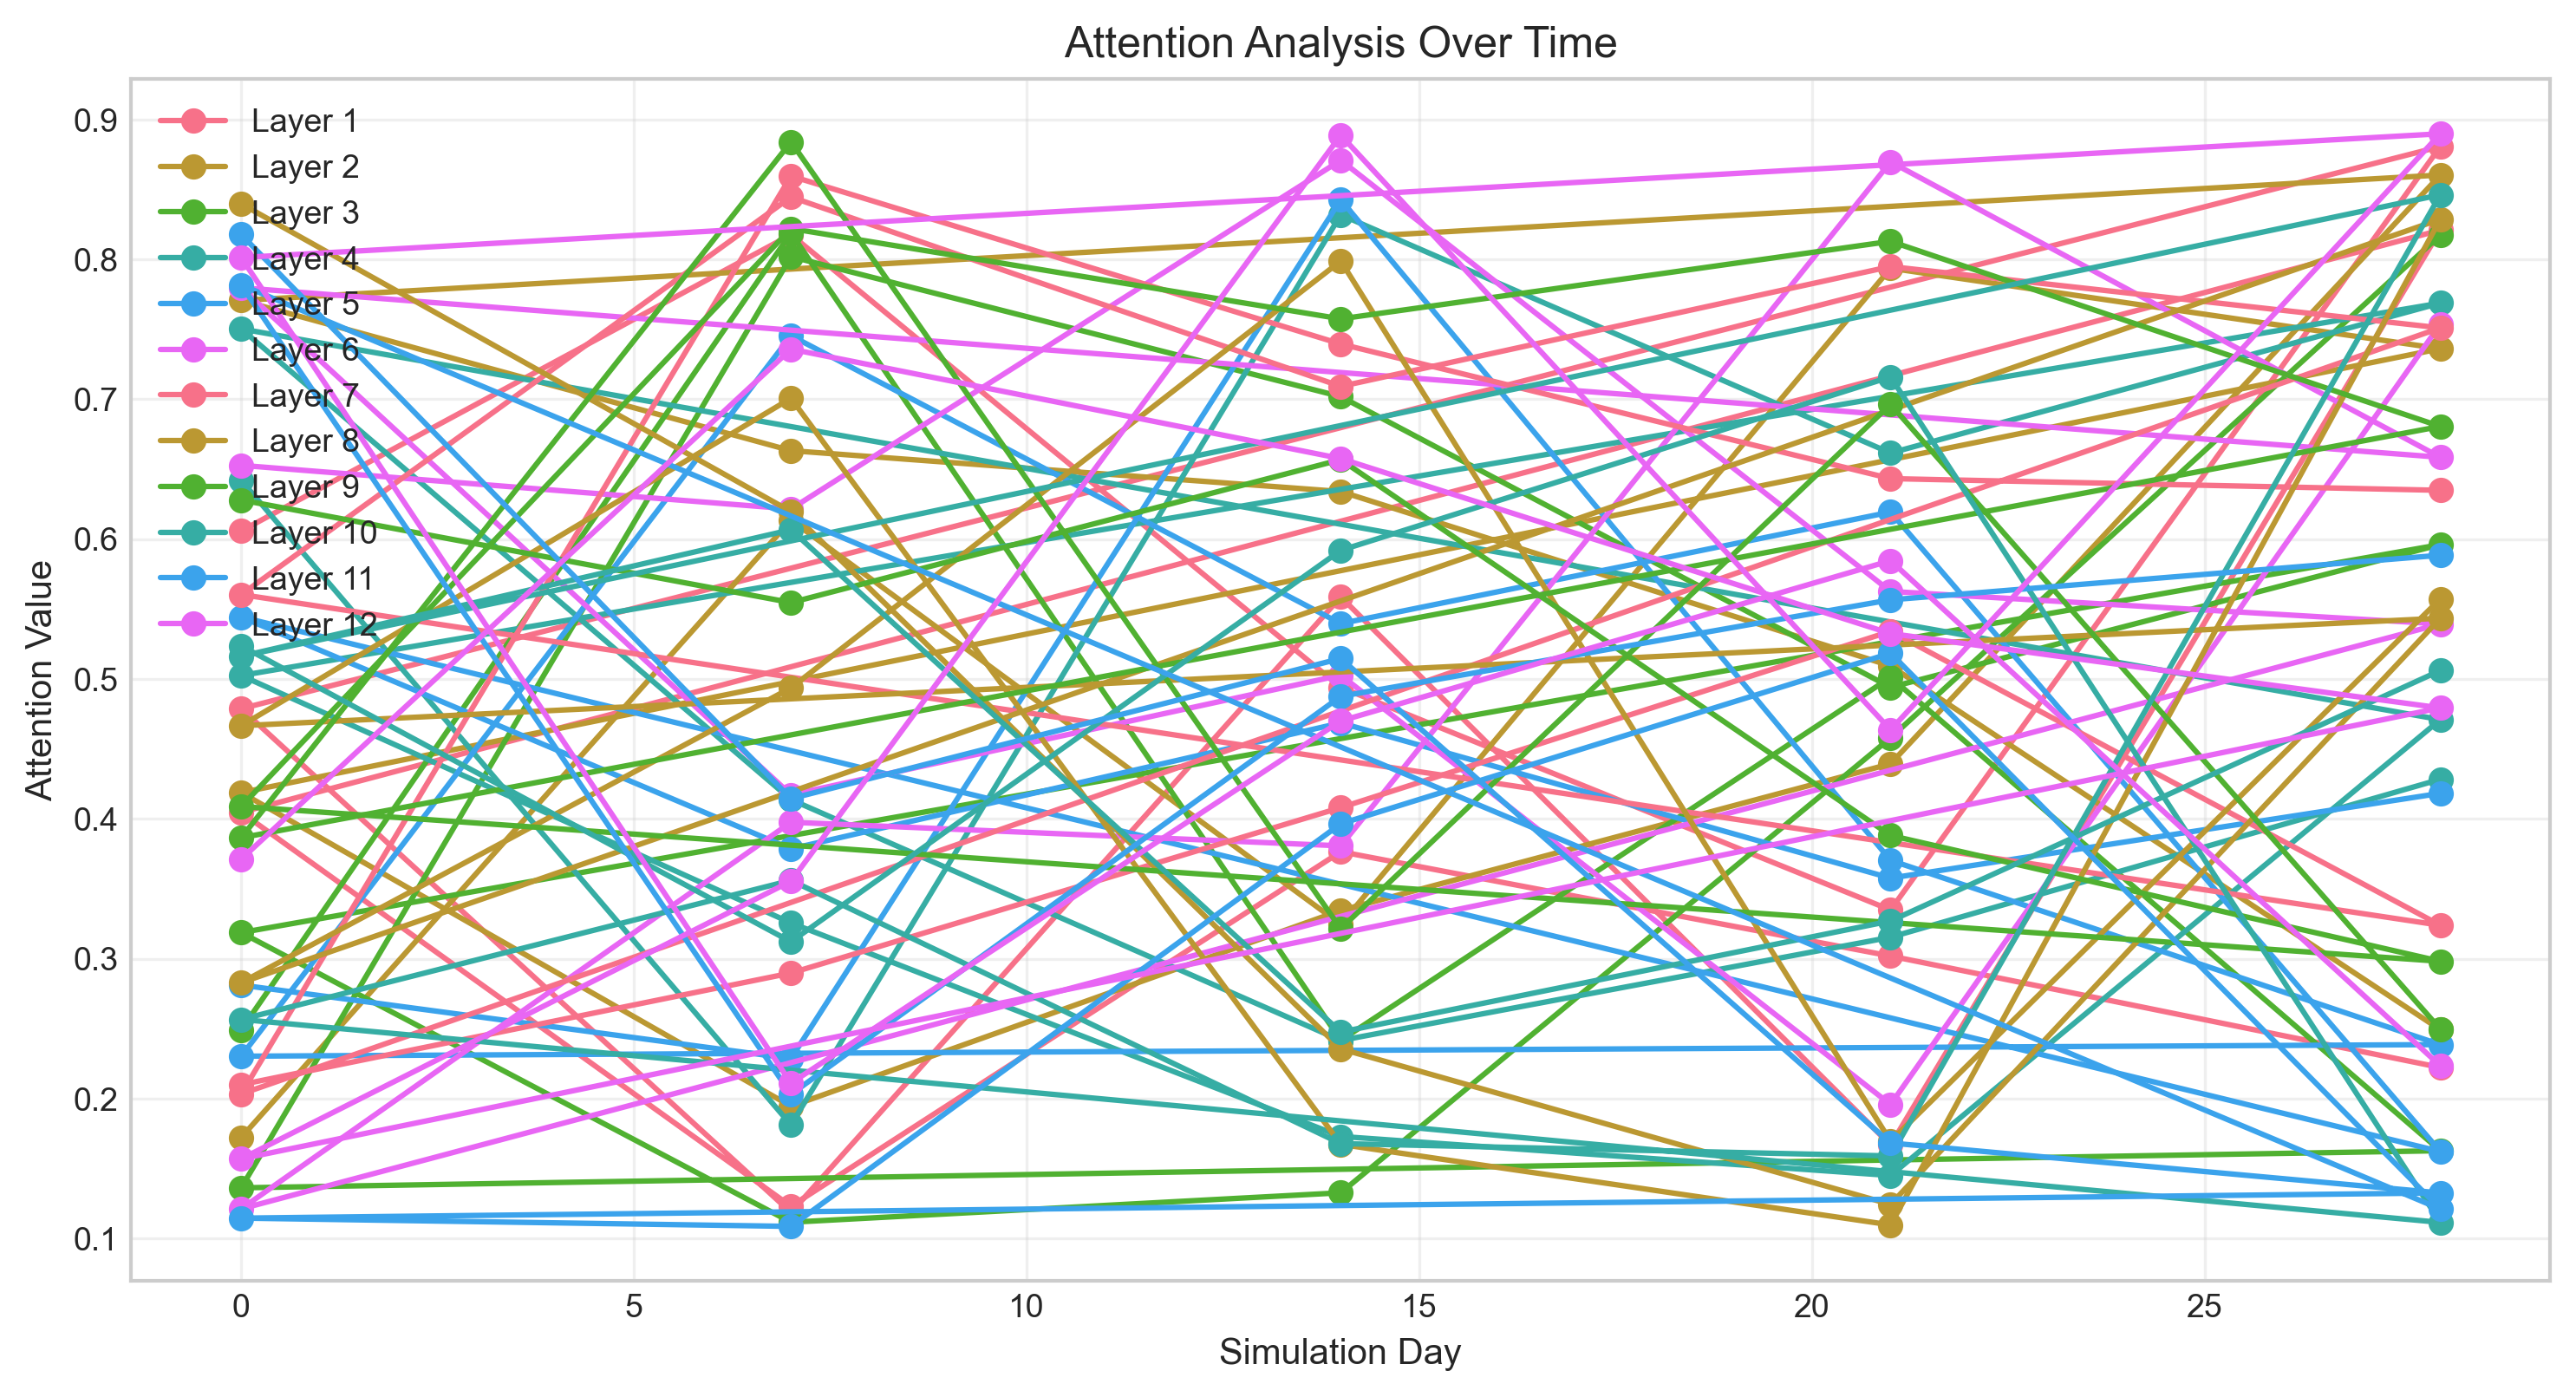

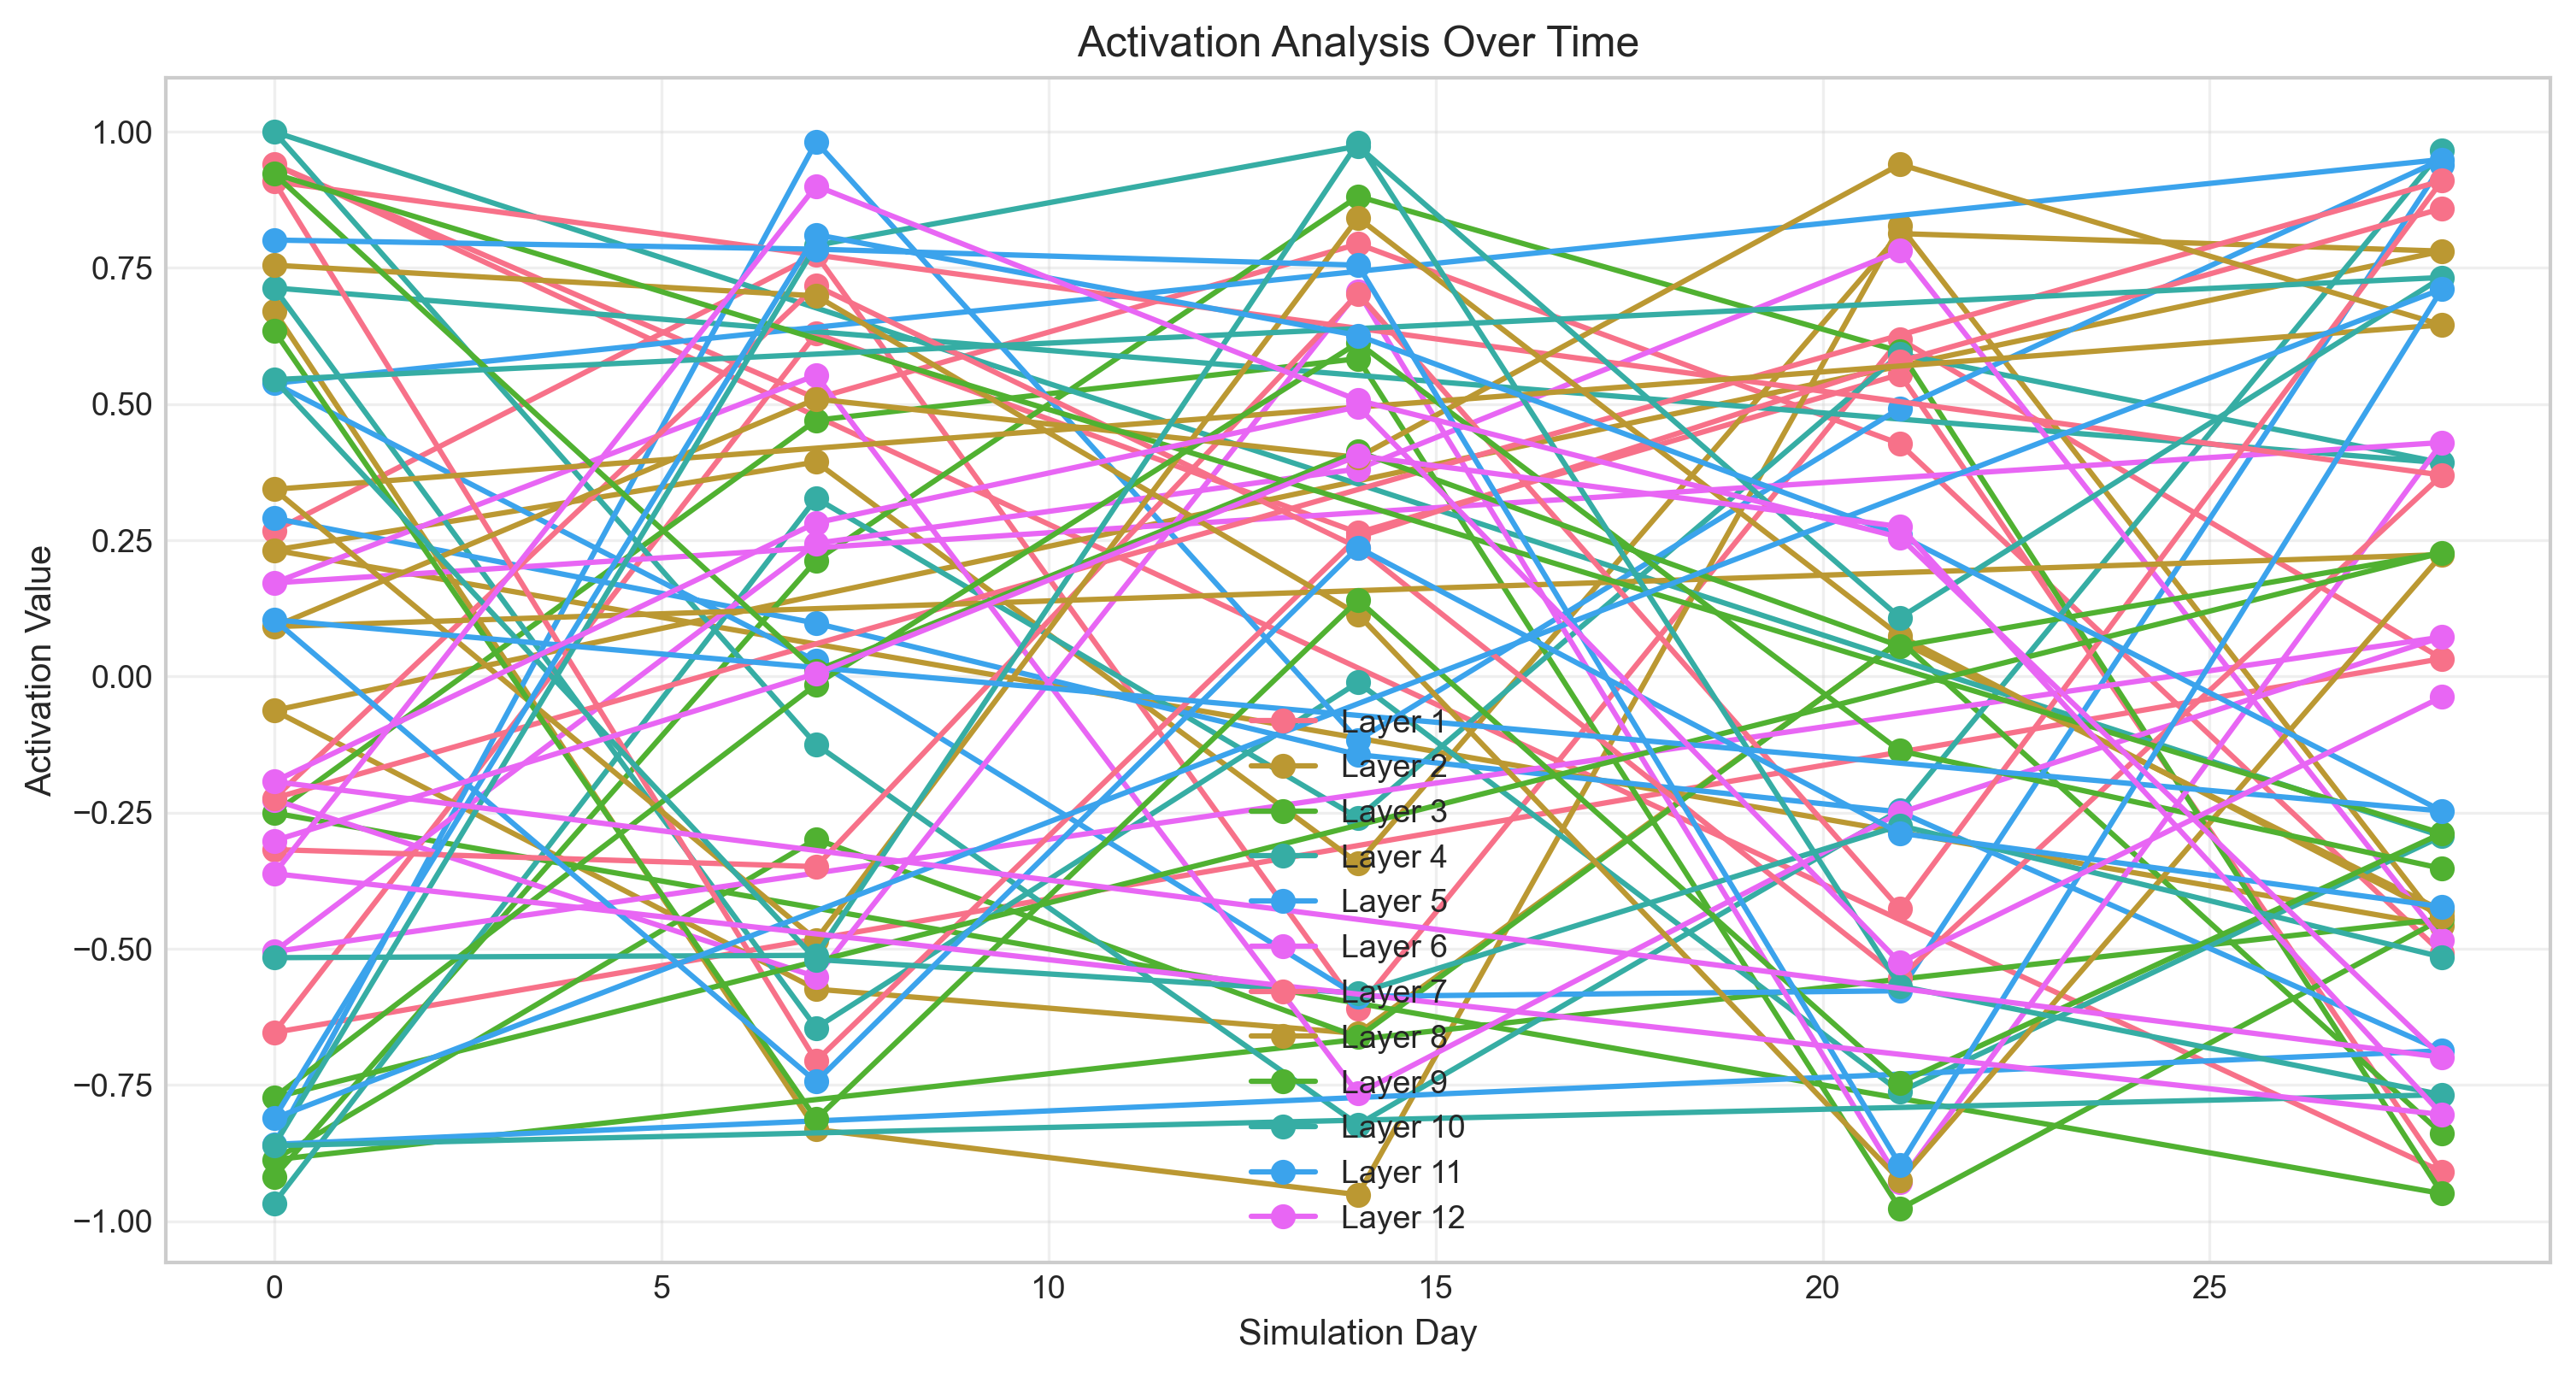

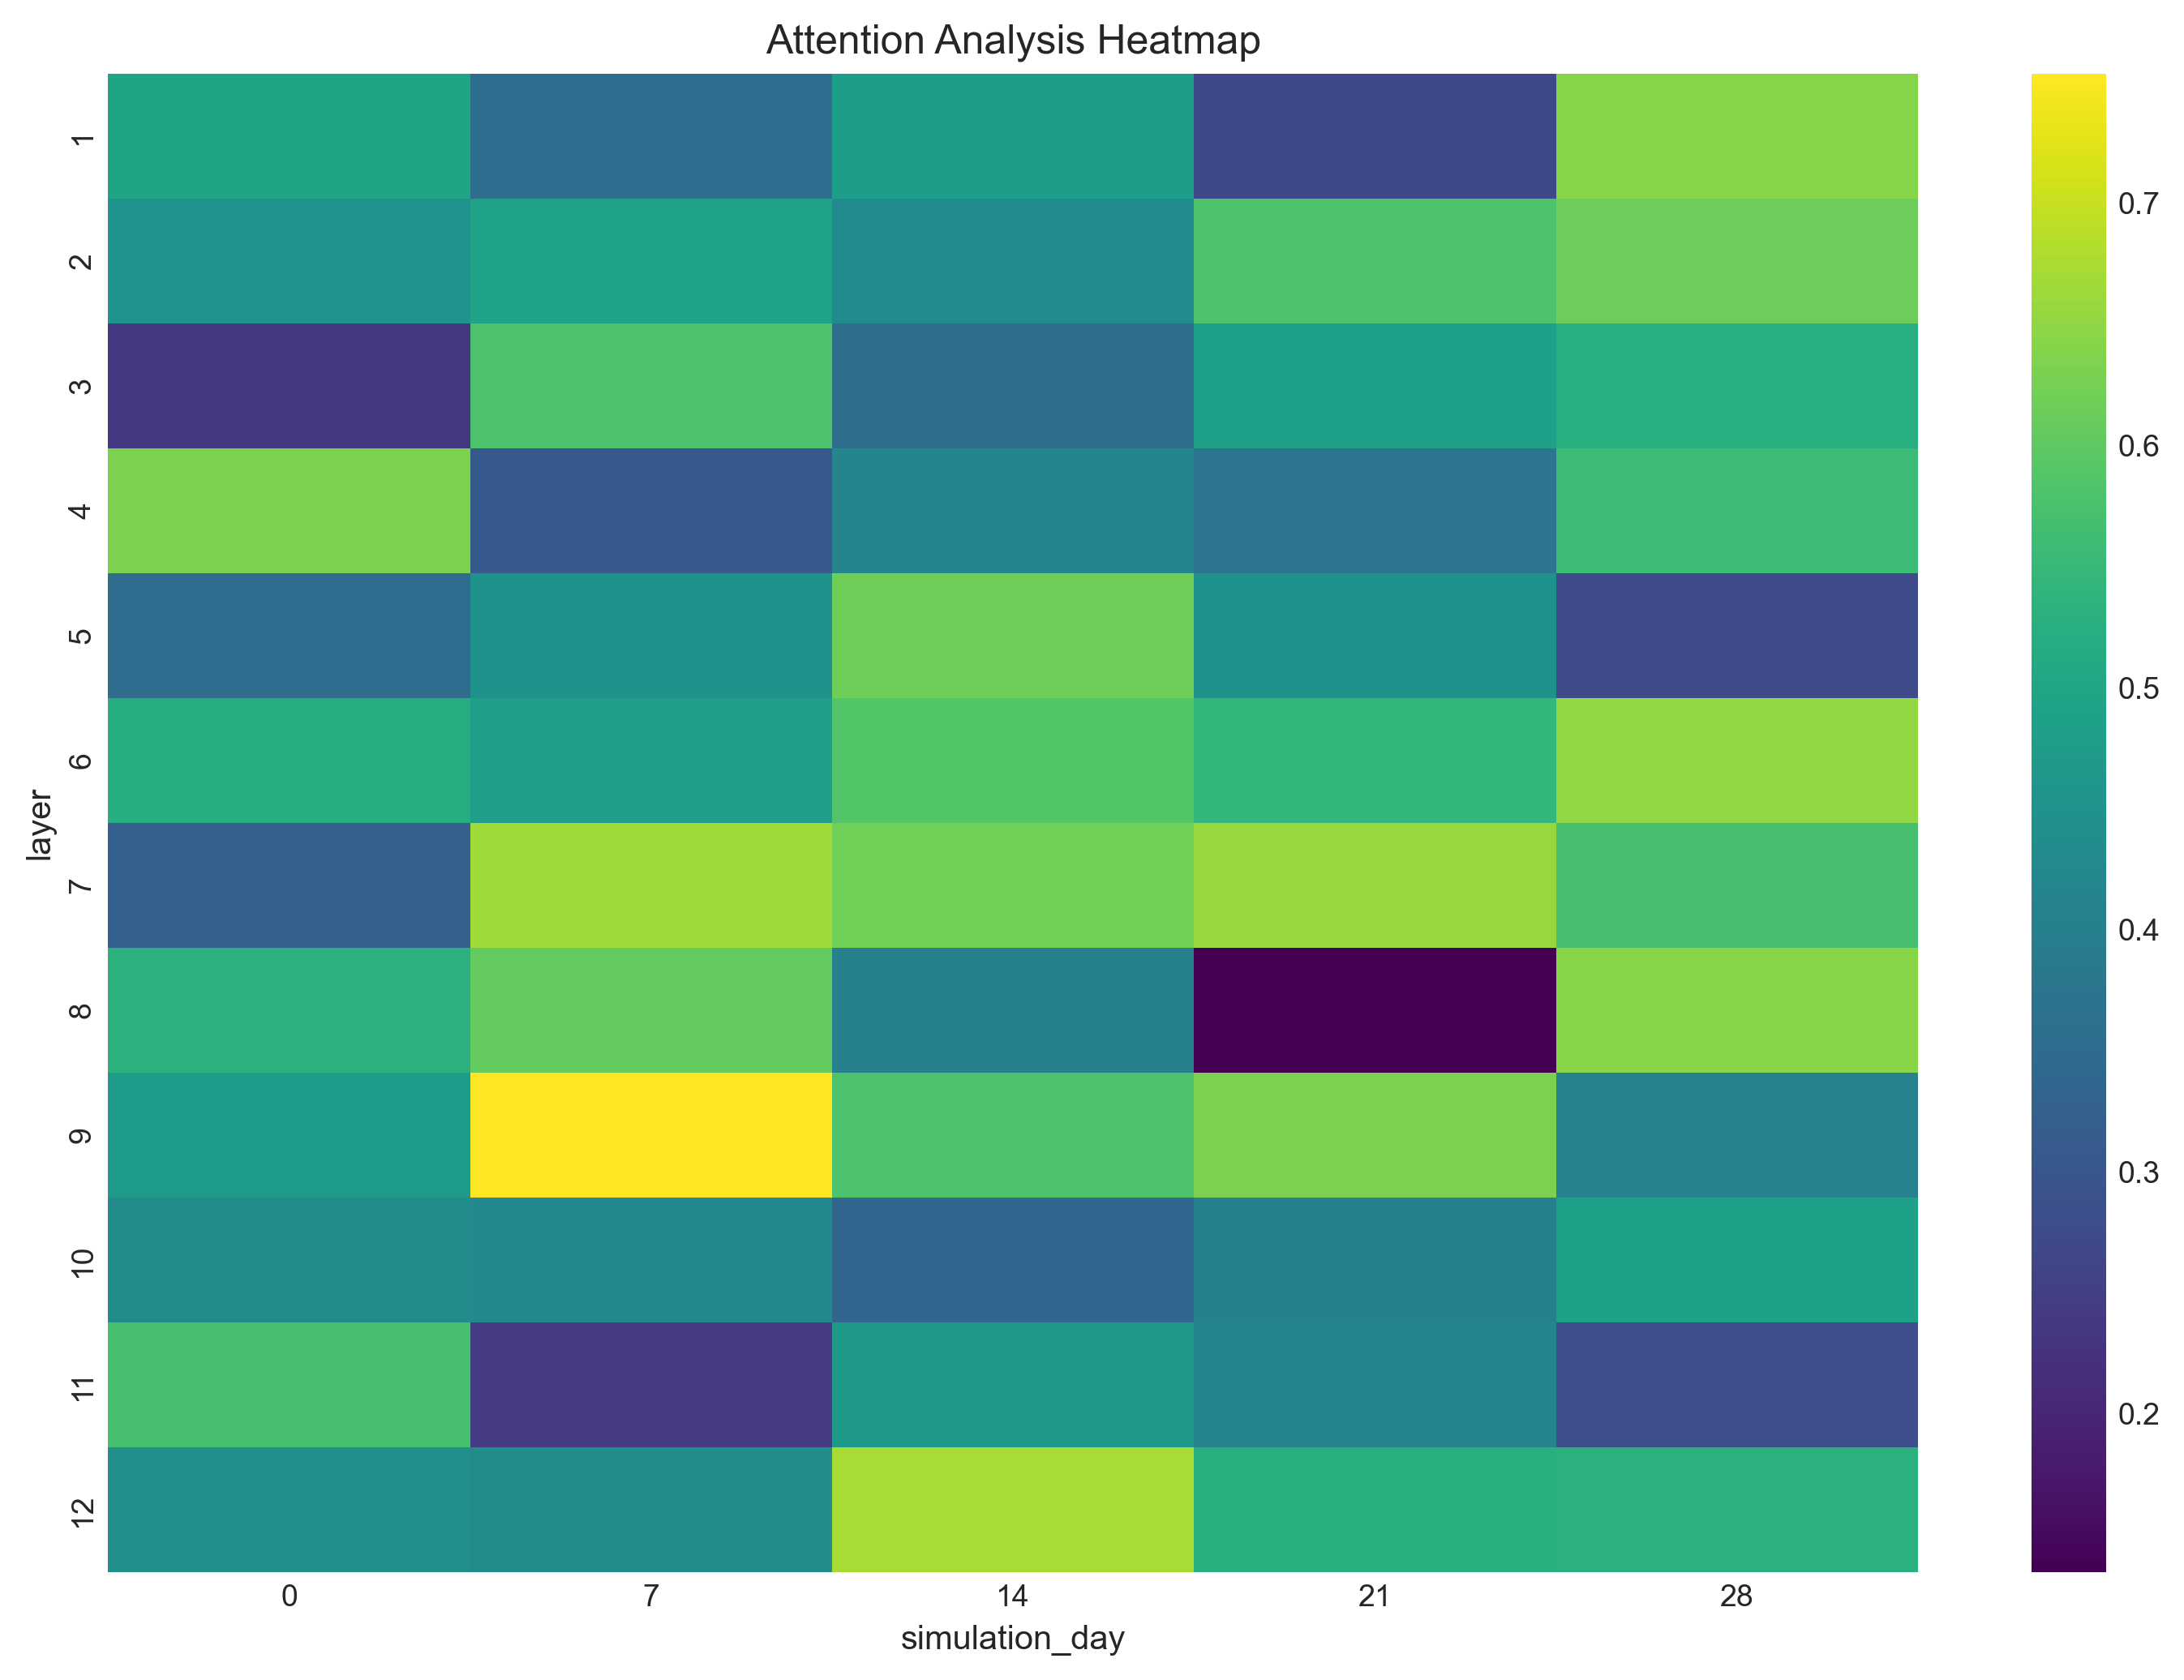

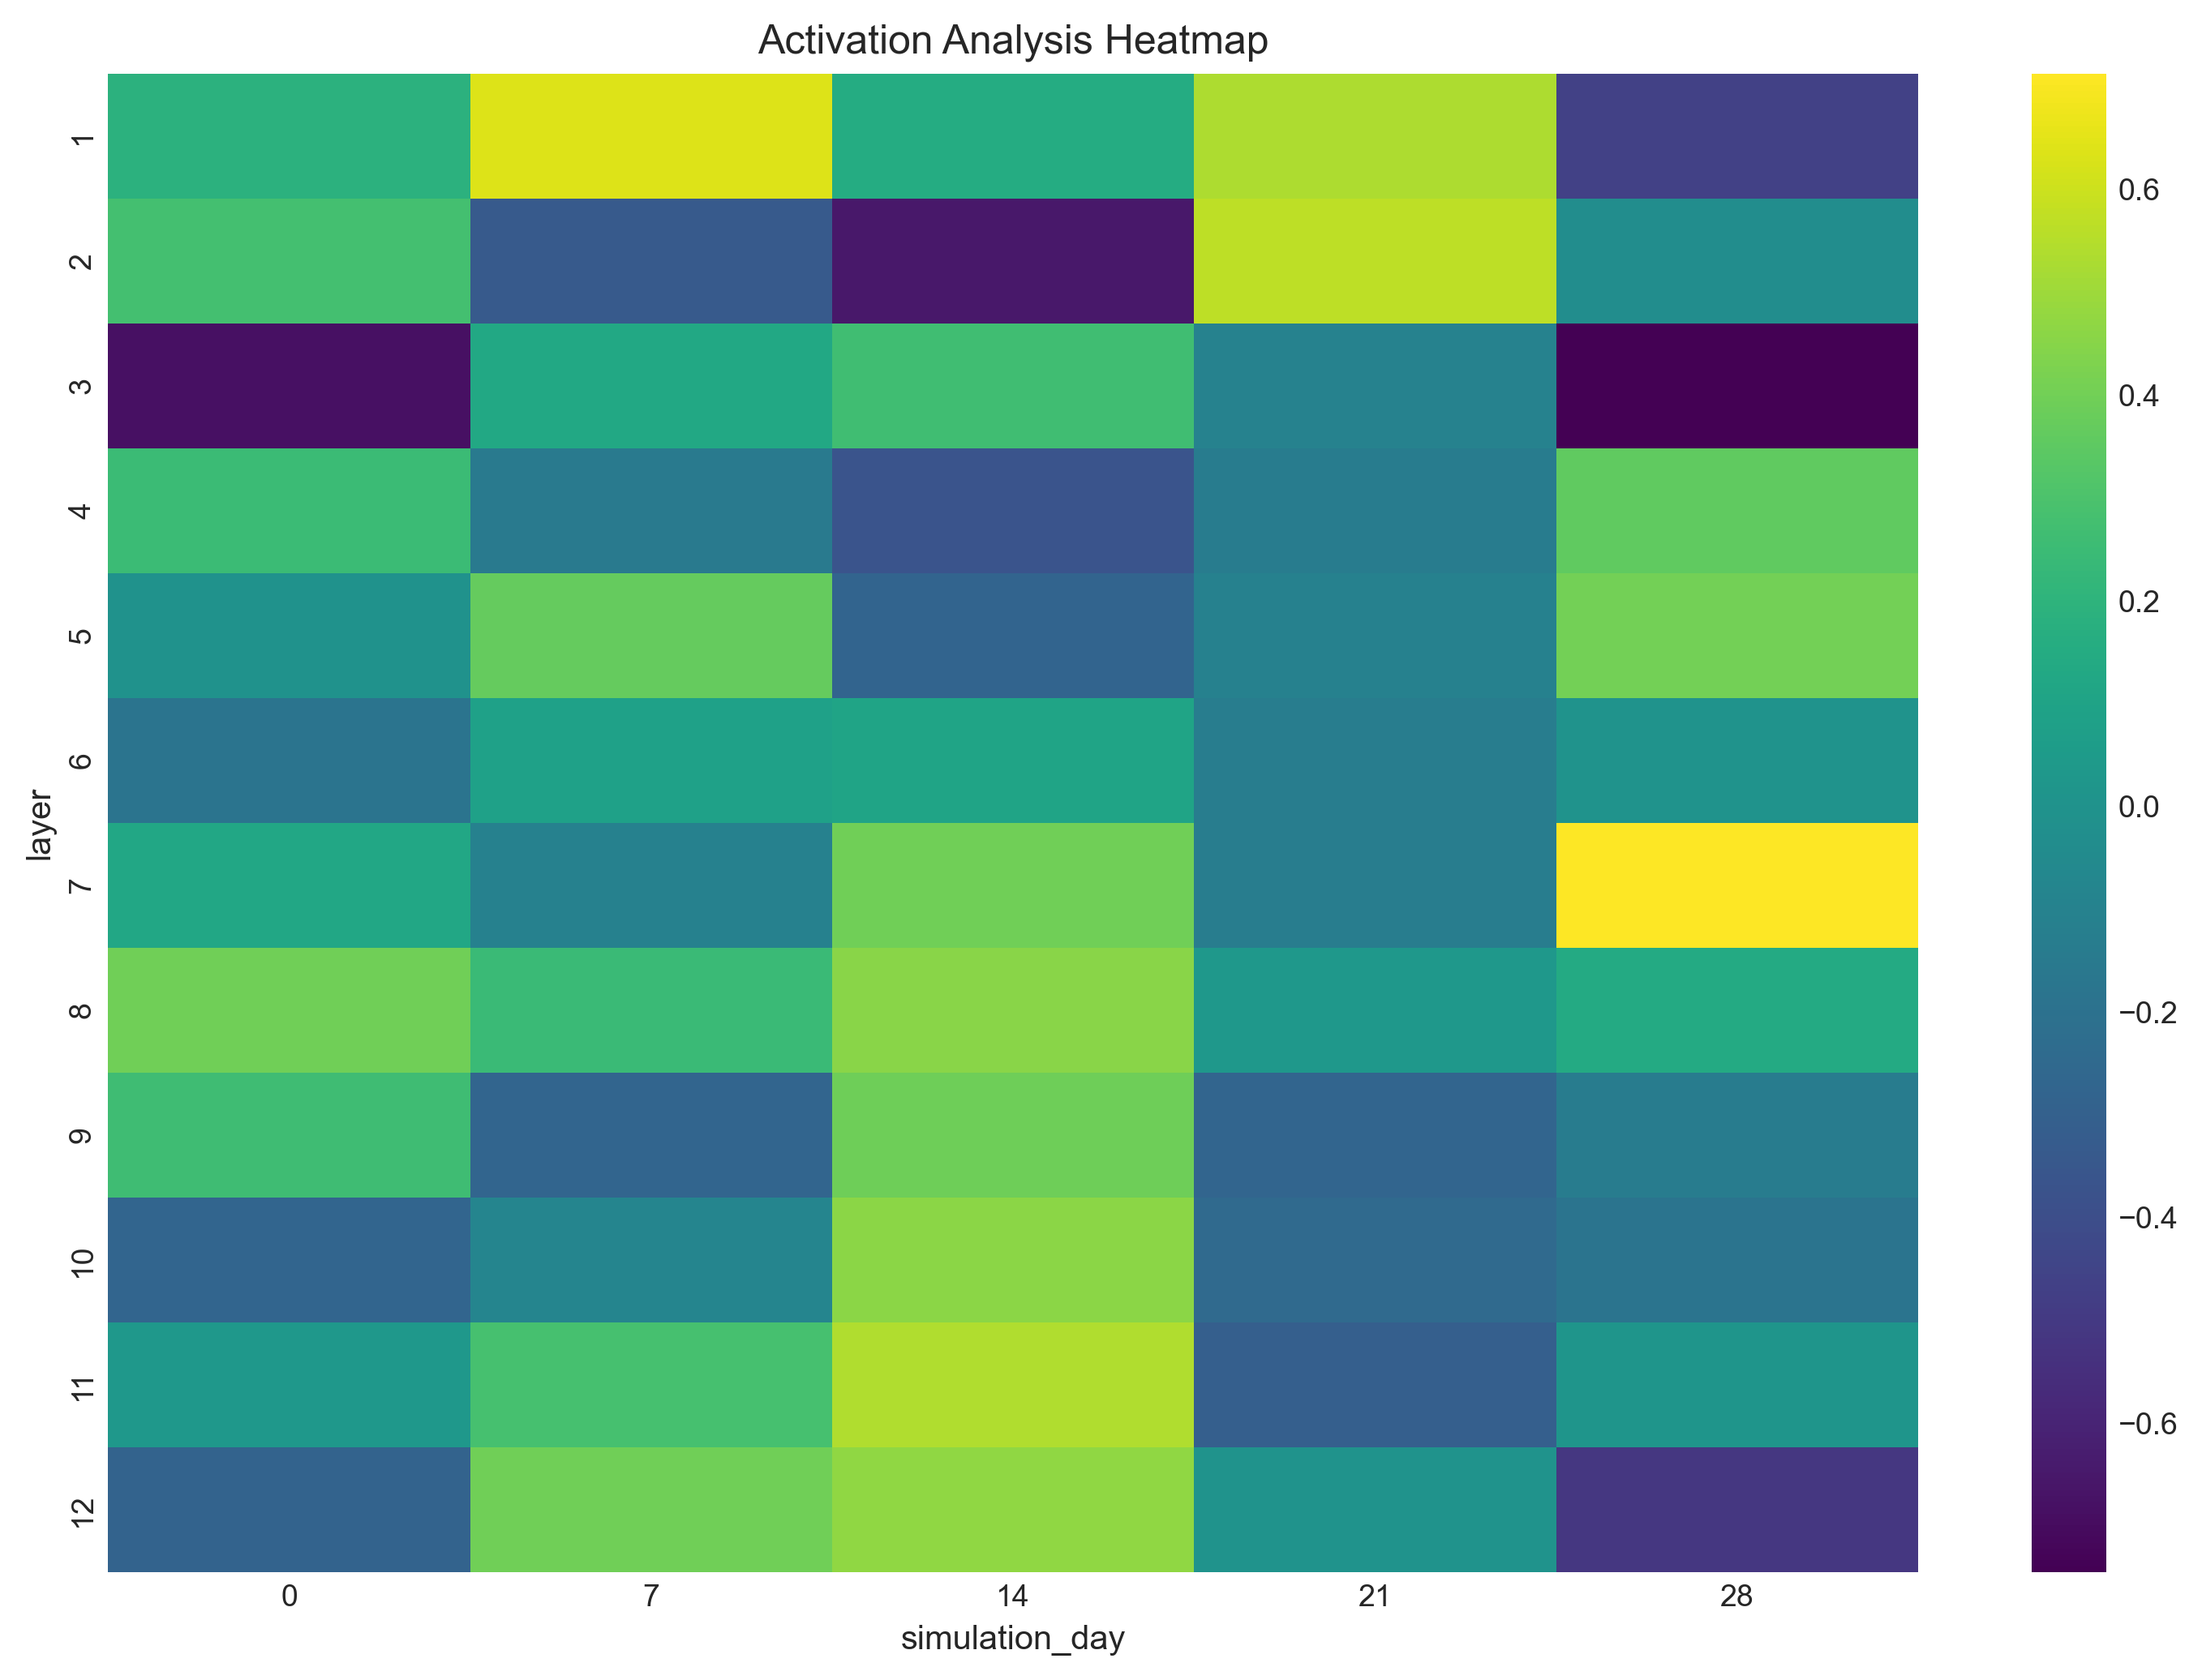

In [20]:
# Visualize mechanistic trends
for analysis_type in analysis_types:
    fig = viz_toolkit.plot_mechanistic_analysis(
        mechanistic_data, analysis_type, plot_type="line"
    )
    plt.savefig(output_dir / f"{analysis_type}_mechanistic_trends.png", bbox_inches='tight')
    plt.show()

# %%
# Mechanistic heatmaps
for analysis_type in analysis_types:
    fig = viz_toolkit.plot_mechanistic_analysis(
        mechanistic_data, analysis_type, plot_type="heatmap"
    )
    plt.savefig(output_dir / f"{analysis_type}_mechanistic_heatmap.png", bbox_inches='tight')
    plt.show()

## Cross-Temporal Correlations

In [21]:
# Analyze correlations between assessment scores and mechanistic data
print("=== Cross-Temporal Correlation Analysis ===")

correlations = longitudinal_analyzer.analyze_cross_temporal_correlations(
    assessment_data, mechanistic_data
)

for correlation_key, lag_correlations in correlations.items():
    print(f"\n{correlation_key}:")
    for lag_key, lag_data in lag_correlations.items():
        if lag_data:
            avg_correlation = np.mean([c['correlation'] for c in lag_data])
            significant_count = sum(1 for c in lag_data if c['significant'])
            print(f"  {lag_key}: avg_corr={avg_correlation:.3f}, significant={significant_count}/{len(lag_data)}")

=== Cross-Temporal Correlation Analysis ===

phq9_attention:
  lag_0_days: avg_corr=0.130, significant=0/3
  lag_7_days: avg_corr=-0.190, significant=0/3
  lag_14_days: avg_corr=-0.158, significant=1/3

gad7_attention:
  lag_0_days: avg_corr=0.182, significant=0/3
  lag_7_days: avg_corr=0.340, significant=0/3
  lag_14_days: avg_corr=-0.485, significant=0/3

pss10_attention:
  lag_0_days: avg_corr=0.074, significant=0/3
  lag_7_days: avg_corr=-0.523, significant=0/3
  lag_14_days: avg_corr=0.296, significant=0/3


## Trajectory Similarity Analysis

In [22]:
# Calculate trajectory similarity between personas
for assessment_type in assessment_types:
    print(f"\n=== {assessment_type.upper()} Trajectory Similarity ===")
    
    similarity_results = longitudinal_analyzer.calculate_trajectory_similarity(
        assessment_data, assessment_type
    )
    
    if 'error' not in similarity_results:
        print(f"Mean Similarity: {similarity_results['mean_similarity']:.3f}")
        print(f"Std Similarity: {similarity_results['std_similarity']:.3f}")
        print(f"Similarity Method: {similarity_results['similarity_method']}")
        
        # Show similarity matrix
        similarity_matrix = similarity_results['similarity_matrix']
        persona_ids = similarity_results['persona_ids']
        
        print("\nSimilarity Matrix:")
        print("          ", end="")
        for pid in persona_ids:
            print(f"{pid:>10}", end="")
        print()
        
        for i, pid1 in enumerate(persona_ids):
            print(f"{pid1:>10}", end="")
            for j, pid2 in enumerate(persona_ids):
                sim = similarity_matrix[i, j]
                if np.isnan(sim):
                    print(f"{'N/A':>10}", end="")
                else:
                    print(f"{sim:>10.3f}", end="")
            print()


=== PHQ9 Trajectory Similarity ===
Mean Similarity: 0.691
Std Similarity: 0.246
Similarity Method: correlation

Similarity Matrix:
           persona_1 persona_2 persona_3
 persona_1     1.000     0.474     0.726
 persona_2     0.474     1.000     0.408
 persona_3     0.726     0.408     1.000

=== GAD7 Trajectory Similarity ===
Mean Similarity: 0.350
Std Similarity: 0.515
Similarity Method: correlation

Similarity Matrix:
           persona_1 persona_2 persona_3
 persona_1     1.000    -0.188     0.427
 persona_2    -0.188     1.000    -0.163
 persona_3     0.427    -0.163     1.000

=== PSS10 Trajectory Similarity ===
Mean Similarity: 0.744
Std Similarity: 0.256
Similarity Method: correlation

Similarity Matrix:
           persona_1 persona_2 persona_3
 persona_1     1.000     0.851     0.679
 persona_2     0.851     1.000     0.318
 persona_3     0.679     0.318     1.000


## Interactive Dashboard


In [27]:
# Create proper persona data structure for dashboard
print("Creating persona data for dashboard...")

# Create persona data with trait information
persona_dashboard_data = []
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

for persona_id in mechanistic_data['persona_id'].unique():
    for day in mechanistic_data['simulation_day'].unique():
        # Get baseline trait values (simulate from persona config or use defaults)
        baseline_traits = {
            'openness': 0.6,
            'conscientiousness': 0.7,
            'extraversion': 0.5,
            'agreeableness': 0.8,
            'neuroticism': 0.3
        }
        
        # Add some drift over time
        for trait in traits:
            drift = np.random.normal(0, 0.01) * (day / 30)  # Small drift over time
            current_value = max(0.0, min(1.0, baseline_traits[trait] + drift))
            
            persona_dashboard_data.append({
                'persona_id': persona_id,
                'simulation_day': day,
                'trait': trait,
                'trait_value': current_value
            })

persona_dashboard_df = pd.DataFrame(persona_dashboard_data)
print(f"Created persona dashboard data: {len(persona_dashboard_df)} records")

Creating persona data for dashboard...
Created persona dashboard data: 75 records


In [28]:
# Create interactive dashboard
print("Creating interactive dashboard...")
print(f"Assessment data shape: {assessment_data.shape}")
print(f"Mechanistic data shape: {mechanistic_data.shape}")
print(f"Persona dashboard data shape: {persona_dashboard_df.shape}")
print(f"Persona dashboard columns: {persona_dashboard_df.columns.tolist()}")

try:
    dashboard = viz_toolkit.create_interactive_dashboard(
        assessment_data, mechanistic_data, persona_dashboard_df
    )
    
    # Save dashboard
    dashboard.write_html(str(output_dir / "interactive_dashboard.html"))
    print(f"Interactive dashboard saved to: {output_dir / 'interactive_dashboard.html'}")
    
except Exception as e:
    print(f"Error creating dashboard: {e}")
    import traceback
    traceback.print_exc()

Creating interactive dashboard...
Assessment data shape: (45, 9)
Mechanistic data shape: (180, 8)
Persona dashboard data shape: (75, 4)
Persona dashboard columns: ['persona_id', 'simulation_day', 'trait', 'trait_value']
Interactive dashboard saved to: ../../data/results/longitudinal_analysis/interactive_dashboard.html


## Summary and Export

In [79]:
# Helper function to convert numpy types to native Python types
def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types for JSON serialization."""
    import numpy as np
    import pandas as pd
    
    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    elif isinstance(obj, pd.DataFrame):
        # Convert DataFrame to dict with converted values
        return convert_numpy_types(obj.to_dict('records'))
    elif isinstance(obj, pd.Series):
        # Convert Series to list with converted values
        return convert_numpy_types(obj.tolist())
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.int64, np.int32, np.int16, np.int8, np.uint64, np.uint32, np.uint16, np.uint8)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    elif isinstance(obj, np.bytes_):
        return str(obj)
    elif isinstance(obj, np.str_):
        return str(obj)
    elif hasattr(obj, 'item'):  # Handle other numpy scalars
        return obj.item()
    elif hasattr(obj, 'dtype'):  # Handle pandas/numpy objects with dtype
        if hasattr(obj, 'tolist'):
            return obj.tolist()
        elif hasattr(obj, 'item'):
            return obj.item()
        else:
            return str(obj)
    elif str(type(obj)).startswith("<class 'numpy."):  # Catch any remaining numpy types
        try:
            return obj.item()
        except:
            return str(obj)
    else:
        return obj

In [80]:
summary_stats = {
    'total_assessments': int(len(assessment_data)),
    'unique_personas': convert_numpy_types(assessment_data['persona_id'].nunique()),
    'assessment_types': convert_numpy_types(assessment_data['assessment_type'].unique().tolist()),
    'simulation_days': convert_numpy_types(assessment_data['simulation_day'].max()),
    'mechanistic_records': int(len(mechanistic_data)),
    'analysis_timestamp': datetime.now().isoformat()
}

# Convert summary_stats to ensure all values are JSON serializable
summary_stats = convert_numpy_types(summary_stats)

print("=== Longitudinal Analysis Summary ===")
print(json.dumps(summary_stats, indent=2))

=== Longitudinal Analysis Summary ===
{
  "total_assessments": 45,
  "unique_personas": 3,
  "assessment_types": [
    "phq9",
    "gad7",
    "pss10"
  ],
  "simulation_days": 28,
  "mechanistic_records": 180,
  "analysis_timestamp": "2025-07-31T02:32:08.244402"
}


In [ ]:
# TODO: add full export